#Perbandingan Kinerja Algoritma Integrated Moving Average (ARIMA) dan Long Short-Term Memory (LSTM) dalam Prediksi Penjualan Toko Loa Kim Jong

## 1. Required Libraries

In [465]:
# !pip install split-folders

Data Manipulation & Processing

In [466]:
import pandas as pd
import numpy as np

Data Visualization

In [467]:
import matplotlib.pyplot as plt
import seaborn as sns

Time Series Analysis & Forecasting

In [468]:
from statsmodels.tsa.arima.model import ARIMA

Model Evaluation Metrics

In [469]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

LSTM Model

In [470]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

Data Preprocessing & Normalization

In [471]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import scipy.stats as stats

Mathematics & Statistical Operations

In [472]:
import math

Calendar

In [473]:
import calendar

## 2. Data Loading

Mengambil data dari Google Sheets dan mengonversinya menjadi DataFrame Pandas

In [474]:
def load_data_from_google_sheets(sheet_url):
    sheet_url = sheet_url.replace('/edit?usp=sharing', '/gviz/tq?tqx=out:csv')
    df = pd.read_csv(sheet_url)
    return df

Mengambil data dari Google Sheets dan menyimpannya dalam variabel df sebagai DataFrame Pandas

In [616]:
sheet_url = "https://docs.google.com/spreadsheets/d/1ZwOzvturDWqYXVXOGfTQVFY0Bxfv1zZ_/edit?usp=sharing&ouid=104512244025441839866&rtpof=true&sd=true"
# df = load_data_from_google_sheets(sheet_url)
# df = pd.read_csv("D:/Arya/Project/lala/data/tokped_tiny.csv")
csv_path = "D:/Arya/Project/lala/data/tokped.csv"
df = pd.read_csv(csv_path)

In [476]:
df.head()

,Invoice,Tanggal Pembayaran,Status Terakhir,Nama Produk,Jumlah Produk Dibeli,Harga Jual (IDR),Total Penjualan (IDR)
0,INV/20200507/XX/V/537956873,5/8/2020 10:19,Pesanan Selesai,"AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMUM...",10.0,7000.0,70000.0
1,INV/20200508/XX/V/538745415,5/8/2020 18:00,Pesanan Selesai,"AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMUM...",30.0,7000.0,210000.0
2,INV/20200510/XX/V/540334166,5/10/2020 20:01,Pesanan Selesai,bushing boshing bos bearing kipas angin Rrt/umum,10.0,2200.0,152000.0
3,INV/20200510/XX/V/540334166,5/10/2020 20:01,Pesanan Selesai,AS Exsos kipas lobang 2 model Maspion Nasional.,10.0,6000.0,152000.0
4,INV/20200510/XX/V/540334166,5/10/2020 20:01,Pesanan Selesai,"AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMUM...",10.0,7000.0,152000.0


## 3. Data Preparation

Mengidentifikasi informasi dataset

In [477]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32689 entries, 0 to 32688
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Invoice                32575 non-null  object 
 1   Tanggal Pembayaran     32575 non-null  object 
 2   Status Terakhir        32571 non-null  object 
 3   Nama Produk            32575 non-null  object 
 4   Jumlah Produk Dibeli   32575 non-null  float64
 5   Harga Jual (IDR)       32575 non-null  float64
 6   Total Penjualan (IDR)  32575 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.7+ MB


### 3.1. Mengonversi Kolom Tanggal (Date) ke Tipe Data `datetime`

Mengonversi kolom 'Date' ke tipe datetime

In [478]:
df['Tanggal Pembayaran'] = pd.to_datetime(df['Tanggal Pembayaran'], errors='coerce')

 **Notes:** `error='coerce'` untuk menangani error.

### 3.2. Memeriksa Missing Values

Memeriksa missing values

In [479]:
missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}")

Missing values per column:
Invoice                  114
Tanggal Pembayaran       114
Status Terakhir          118
Nama Produk              114
Jumlah Produk Dibeli     114
Harga Jual (IDR)         114
Total Penjualan (IDR)    114
dtype: int64


Persentase missing values

In [480]:
missing_percentage = (missing_values / len(df)) * 100
print(f"\nPersentase missing values:\n{missing_percentage}")


Persentase missing values:
Invoice                  0.348741
Tanggal Pembayaran       0.348741
Status Terakhir          0.360978
Nama Produk              0.348741
Jumlah Produk Dibeli     0.348741
Harga Jual (IDR)         0.348741
Total Penjualan (IDR)    0.348741
dtype: float64


### 3.3. Memeriksa Duplikasi Data

Memeriksa duplikasi data

In [481]:
duplicates = df.duplicated()
print(f"Jumlah duplikasi data: {duplicates.sum()}")

Jumlah duplikasi data: 113


### 3.4. Menambahkan Kolom Tahun, Bulan, dan Hari dari Kolom `Date`

> Tahap ini ditujukan untuk analisis berdasarkan waktu yang berguna untuk menambahkan kolom `Year`, `Month`, dan `Day` ke dataset agar lebih mudah dalam analisis waktu.

Menambahkan kolom tahun, bulan, dan hari

In [482]:
df['Year'] = df['Tanggal Pembayaran'].dt.year
df['Month'] = df['Tanggal Pembayaran'].dt.month
df['Day'] = df['Tanggal Pembayaran'].dt.day

### 3.5. Mengidentifaksi Outlier

> Tahap ini ditujukan untuk mendeteksi dan menangani outliers menggunakan Z-Score.

In [483]:
df['Z_Score_Total_Penjualan'] = zscore(df['Total Penjualan (IDR)'])
df['Z_Score_Harga_Jual'] = zscore(df['Harga Jual (IDR)'])

Menyaring outliers

In [484]:
outliers_nominal = df[df['Z_Score_Total_Penjualan'].abs() > 3]
outliers_balance = df[df['Z_Score_Harga_Jual'].abs() > 3]

Menampilkan jumlah outliers

In [485]:
print(f"Jumlah Outlier Nominal: {len(outliers_nominal)}")
print(f"Jumlah Outlier Balance: {len(outliers_balance)}")

Jumlah Outlier Nominal: 0
Jumlah Outlier Balance: 0


Menampilkan visualisasi outliers

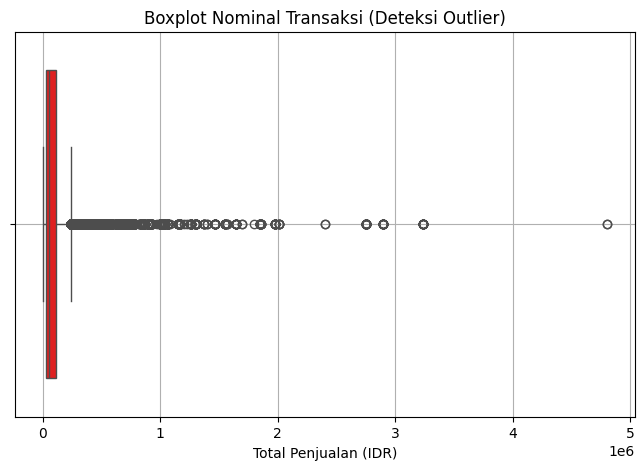

In [486]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Total Penjualan (IDR)'], color='red')
plt.title('Boxplot Nominal Transaksi (Deteksi Outlier)')
plt.grid()
plt.show()

**Important Inferences**  
Grafik boxplot menunjukkan sebagian besar data transaksi berada di sekitar nol. Namun terdapat beberapa titik yang tersebar jauh dari kelompok utama, menandakan adanya transaksi dengan nilai nominal yang jauh lebih besar atau lebih kecil dibandingkan transaksi lainnya.

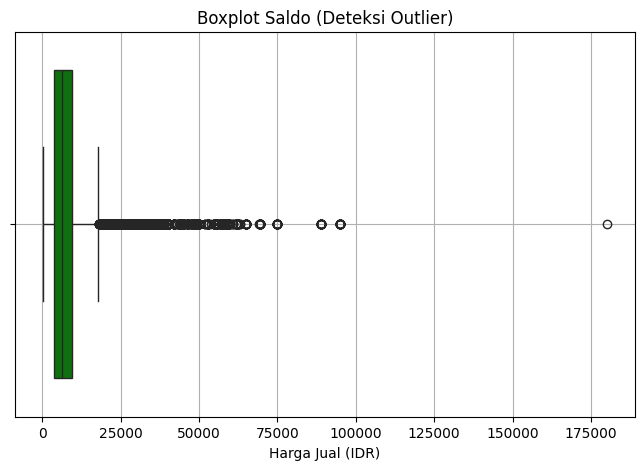

In [487]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Harga Jual (IDR)'], color='green')
plt.title('Boxplot Saldo (Deteksi Outlier)')
plt.grid()
plt.show()

**Important Inferences**  
Grafik boxplot menunjukkan sebagian besar harga jual berada pada rentang relatif rendah dan terkonsentrasi di sekitar nilai mendekati nol. Namun, terdapat beberapa titik data yang berada jauh di sebelah kanan, menandakan adanya outlier atau nilai harga jual yang jauh lebih tinggi dibandingkan dengan sebagian besar data lainnya. Hal ini mengindikasikan adanya beberapa transaksi dengan lonjakan harga jual yang tinggi dibandingkan dengan hari lainnya.

Berdasarkan hasil identifikasi outlier, peneliti memutuskan untuk tidak menghapus nilai-nilai tersebut karena data tersebut dianggap mewakili kejadian yang valid meskipun jarang terjadi. Hal tersebut juga dilakukan untuk menjaga informasi penting pada data.

## 4. Exploratory Data Analysis (EDA)

### 4.1. Analisis Waktu (Date)

#### 4.1.1. Jumlah Transaksi per Hari/Bulan/Tahun

Hitung jumlah transaksi per tahun

In [488]:
transactions_per_year = df.groupby('Year').size()

Hitung jumlah transaksi per bulan

In [489]:
transactions_per_month = df.groupby(['Year', 'Month']).size()

Hitung jumlah transaksi per hari

In [490]:
transactions_per_day = df.groupby('Tanggal Pembayaran').size()

Plot tren transaksi per tahun

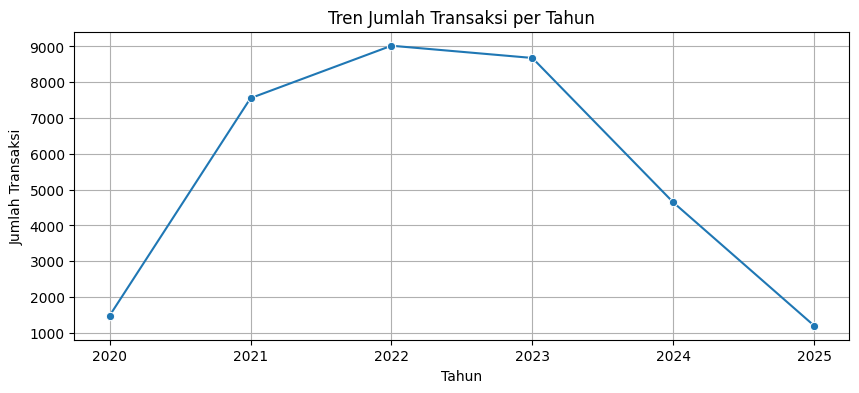

In [491]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=transactions_per_year.index, y=transactions_per_year.values, marker='o')
plt.title("Tren Jumlah Transaksi per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Transaksi")
plt.grid()
plt.show()

**Important Inferences**  
Grafik menunjukkan tren jumlah transaksi per tahun priode 2020 hingga 2025. Lonjakan transaksi pada 2022 sekitar 9.000 transaksi, sebelum menurun bertahap hingga 2024. Penurunan bertahap pada tahun 2023 dan 2024. Penurunan tajam pada 2025 disebabkan karena data yang digunakan hanya mencakup hingga Maret.

Plot tren transaksi per bulan

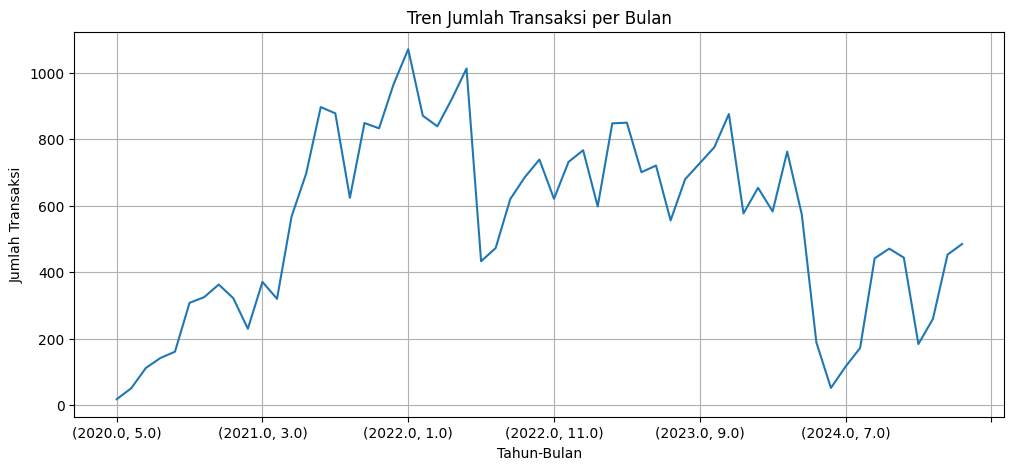

In [492]:
plt.figure(figsize=(12, 5))
transactions_per_month.plot()
plt.title("Tren Jumlah Transaksi per Bulan")
plt.xlabel("Tahun-Bulan")
plt.ylabel("Jumlah Transaksi")
plt.xticks(rotation=0)
plt.grid()
plt.show()

**Important Inferences**  
Grafik menunjukkan tren jumlah transaksi per bulan dari 2020 hingga 2024. hingga mencapai puncaknya pada awal tahun 2022, kemudian mengalami fluktuasi dan penurunan secara bertahap hingga akhir 2023, serta kembali menurun tajam pada pertengahan 2024.

Plot tren transaksi harian

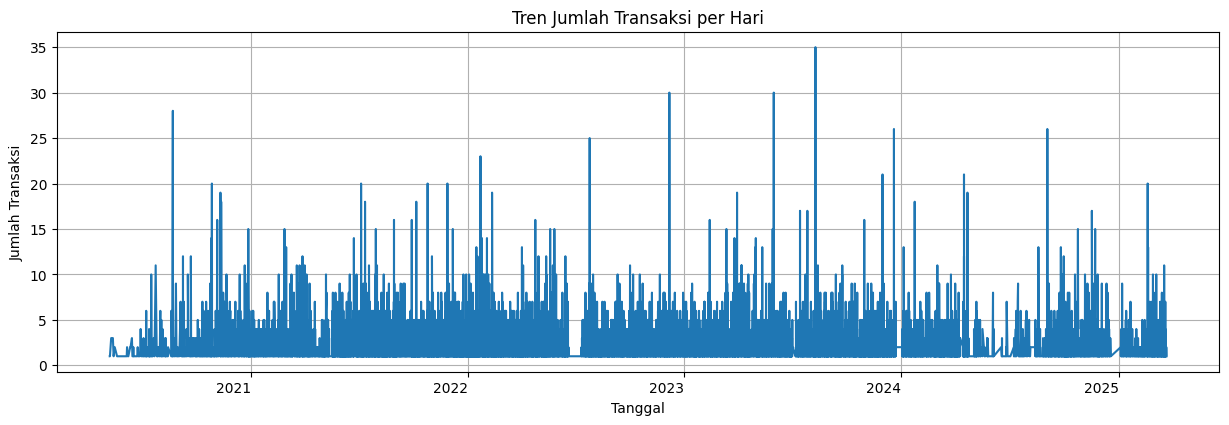

In [493]:
plt.figure(figsize=(15, 5))
transactions_per_day.plot()
plt.title("Tren Jumlah Transaksi per Hari")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Transaksi")
plt.xticks(rotation=0)
plt.grid()
plt.show()

**Important Inferences**  
Grafik menunjukkan tren jumlah transaksi harian dari tahun 2020 hingga awal 2025. Transaksi meningkat pada 2021 dan awal 2022, lalu menurun dan tidak stabil setelahnya.

#### 4.1.2. Hari dengan Transaksi Terbanyak & Tersedikit

Menentukan hari dengan transaksi terbanyak & tersedikit

In [494]:
most_transacted_day = transactions_per_day.idxmax()
least_transacted_day = transactions_per_day.idxmin()

print(f"Hari dengan transaksi terbanyak: {most_transacted_day} ({transactions_per_day.max()} transaksi)")
print(f"Hari dengan transaksi tersedikit: {least_transacted_day} ({transactions_per_day.min()} transaksi)")

Hari dengan transaksi terbanyak: 2023-08-09 10:41:00 (35 transaksi)
Hari dengan transaksi tersedikit: 2020-05-08 10:19:00 (1 transaksi)


#### 4.1.3. Tren Saldo dari Waktu ke Waktu

Agregasi saldo berdasarkan tanggal

In [495]:
balance_trend = df.groupby('Tanggal Pembayaran')['Harga Jual (IDR)'].last()

Plot tren saldo

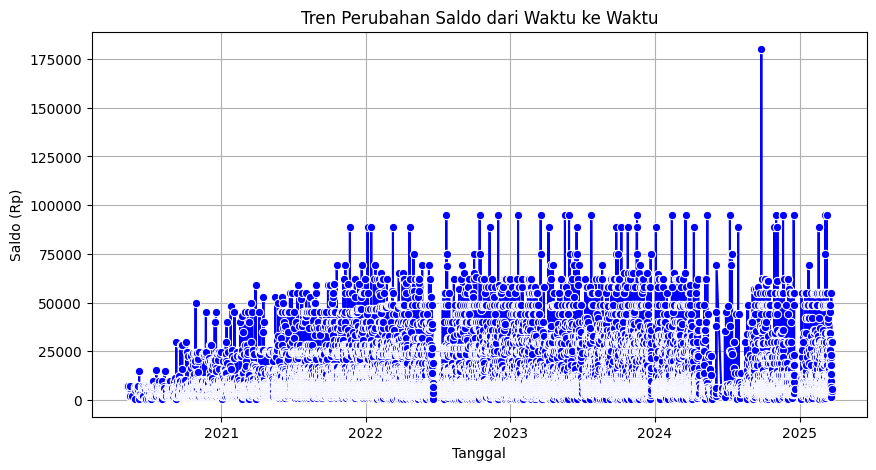

In [496]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=balance_trend.index, y=balance_trend.values, marker='o', color='b')
plt.title("Tren Perubahan Saldo dari Waktu ke Waktu")
plt.xlabel("Tanggal")
plt.ylabel("Saldo (Rp)")
plt.xticks(rotation=0)
plt.grid()
plt.show()

**Important Inferences**  
Grafik menunjukkan perubahan saldo dari 2020 hingga awal 2025 dengan fluktuasi signifikan. Saldo meningkat hingga 2022, kemudian bergerak tidak stabil dengan beberapa lonjakan besar pada periode berikutnya.

### 4.2. Analisis Transaksi (Transaction)

Menghitung jumlah transaksi berdasarkan status terakhir

Membuat dictionary untuk mengganti label status dengan A, B, C, D, dst.

In [497]:
status_counts = df['Status Terakhir'].value_counts()

In [498]:
status_description = {
    'Pesanan Selesai': 'Pesanan berhasil diselesaikan',
    'Dibatalkan Sistem': 'Pesanan dibatalkan oleh sistem',
    'Dibatalkan Penjual': 'Pesanan dibatalkan oleh penjual',
    'Dibatalkan Pembeli': 'Pesanan dibatalkan oleh pembeli'
}

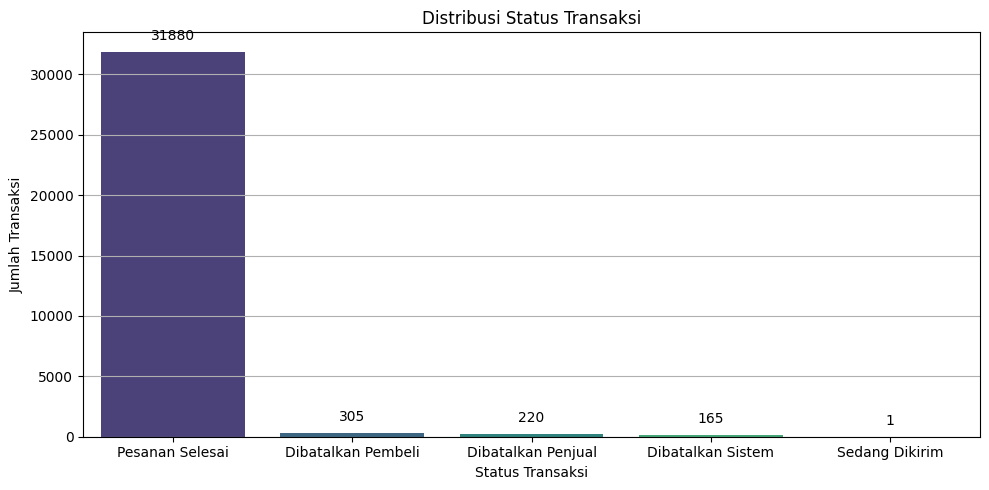

In [499]:
plt.figure(figsize=(10, 5))
sns.barplot(x=status_counts.index, y=status_counts.values, hue=status_counts.index, palette="viridis", legend=False)
plt.title("Distribusi Status Transaksi")
plt.xlabel("Status Transaksi")
plt.ylabel("Jumlah Transaksi")
plt.grid(axis='y')
for i, value in enumerate(status_counts.values):
    plt.text(i, value + 1000, f"{value}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

**Important Inferences**  
Grafik menunjukkan distribusi status transaksi berdasarkan jumlah masing-masing status. Dari hasil visualisasi, terlihat bahwa status “Pesanan Selesai” mendominasi dengan total 31.880 transaksi, jauh lebih tinggi dibandingkan kategori pembatalan lainnya, seperti “Dibatalkan Pembeli” (305 transaksi), “Dibatalkan Penjual” (220 transaksi), dan “Dibatalkan Sistem” (165 transaksi).

##### 4.2.1. Persentase status transaksi

In [500]:
status_percent = (status_counts / status_counts.sum()) * 100
print(f"Persentase Status Transaksi:\n{status_percent}")

Persentase Status Transaksi:
Status Terakhir
Pesanan Selesai       97.878481
Dibatalkan Pembeli     0.936416
Dibatalkan Penjual     0.675447
Dibatalkan Sistem      0.506586
Sedang Dikirim         0.003070
Name: count, dtype: float64


#### 4.2.2. Total dan rata-rata status transaksi

Menghitung total transaksi berdasarkan status transaksi

In [501]:
total_transactions = df.groupby('Status Terakhir')['Total Penjualan (IDR)'].sum()

Menghitung rata-rata transaksi berdasarkan status

In [502]:
average_transactions = df.groupby('Status Terakhir')['Total Penjualan (IDR)'].mean()

Menampilkan total transaksi (IDR)

In [503]:
total_transactions_formatted = total_transactions.apply(lambda x: f"{x:,.0f}")
print(f"Total Transaksi per Status:\n{total_transactions_formatted}\n")

Total Transaksi per Status:
Status Terakhir
Dibatalkan Pembeli       26,909,700
Dibatalkan Penjual       12,941,250
Dibatalkan Sistem        34,809,100
Pesanan Selesai       3,426,327,935
Sedang Dikirim               23,600
Name: Total Penjualan (IDR), dtype: object



Menampilkan rata-rata transaksi

In [504]:
print(f"Rata-rata Transaksi per Status:\n{average_transactions}")

Rata-rata Transaksi per Status:
Status Terakhir
Dibatalkan Pembeli     88228.524590
Dibatalkan Penjual     58823.863636
Dibatalkan Sistem     210964.242424
Pesanan Selesai       107475.782152
Sedang Dikirim         23600.000000
Name: Total Penjualan (IDR), dtype: float64


Menampilkan jumlah status transaksi

In [505]:
status_counts = df['Status Terakhir'].value_counts()
print(f"Jumlah Transaksi per Status:\n{status_counts}\n")

Jumlah Transaksi per Status:
Status Terakhir
Pesanan Selesai       31880
Dibatalkan Pembeli      305
Dibatalkan Penjual      220
Dibatalkan Sistem       165
Sedang Dikirim            1
Name: count, dtype: int64



Barplot rata-rata transaksi

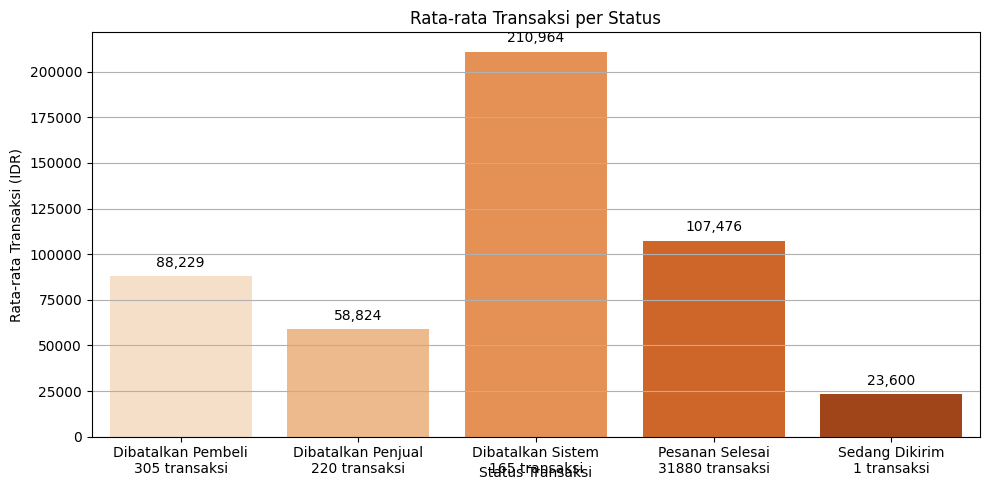

In [506]:
aligned_status_counts = status_counts.reindex(average_transactions.index)
plt.figure(figsize=(10, 5))
sns.barplot(x=average_transactions.index, y=average_transactions.values, hue=average_transactions.index, palette="Oranges", legend=False)
plt.title("Rata-rata Transaksi per Status")
plt.xlabel("Status Transaksi")
plt.ylabel("Rata-rata Transaksi (IDR)")
for i, value in enumerate(average_transactions.values):
    plt.text(i, value + 5000, f"{value:,.0f}", ha='center', fontsize=10, color='black')
for i, count in enumerate(aligned_status_counts.values):
    plt.text(i, -20000, f"{count} transaksi", ha='center', fontsize=10, color='black')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Important Inferences**  
Grafik menunjukkan rata-rata rata-rata nominal transaksi berdasarkan status transaksi.  "Dibatalkan Sistem" lebih tinggi (Rp 210,964) dibandingkan dengan "Pesanan Selesai" (Rp 107,467). Meskipun jumlah transaksi pada "Pesanan Selesai" (31.880 transaksi) jauh lebih banyak. Hal ini menunjukkan bahwa pembatalan oleh sistem umumnya terjadi pada transaksi dengan nilai nominal yang tinggi, sedangkan transaksi yang berhasil diselesaikan cenderung memiliki nilai lebih kecil namun frekuensinya lebih tinggi.

### 4.3. Analisis Deskriptif Nominal

#### 4.3.1. Analisis Deskriptif Nominal - Statistik Total Penjualan (IDR)

In [507]:
print("Statistik Deskriptif Nominal (IDR):")
print(df['Total Penjualan (IDR)'].describe())

Statistik Deskriptif Nominal (IDR):
count    3.257500e+04
mean     1.074818e+05
std      2.133407e+05
min      2.475000e+03
25%      2.490000e+04
50%      5.270000e+04
75%      1.100500e+05
max      4.800000e+06
Name: Total Penjualan (IDR), dtype: float64


#### 4.3.2. Distribusi Nominal Transaksi (Adakah transaksi sangat besar/kecil?)

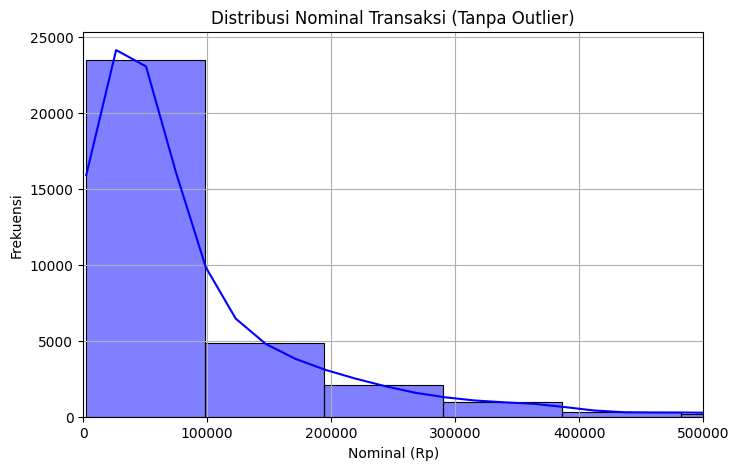

In [508]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Total Penjualan (IDR)'], bins=50, kde=True, color='blue')
plt.xlim(0, 500000)  # Fokus pada transaksi < 500 ribu
plt.title('Distribusi Nominal Transaksi (Tanpa Outlier)')
plt.xlabel('Nominal (Rp)')
plt.ylabel('Frekuensi')
plt.grid()
plt.show()

**Important Inferences**  
Grafik distribusi nominal transaksi tanpa outlier menunjukkan sebagian besar transaksi memiliki nilai yang relatif kecil (sekitar Rp 2.000 - Rp 110.000). Frekuensi transaksi menurun  dengan meningkatnya nominal, menunjukkan bahwa transaksi bernilai besar terjadi lebih jarang. Bentuk histogram condong ke kiri (right-skewed) mengindikasikan bahwa mayoritas transaksi berada pada rentang nilai rendah, sedangkan hanya sedikit transaksi dengan nominal yang lebih tinggi.

In [509]:
df_top_sales = df.sort_values(by='Total Penjualan (IDR)', ascending=False).head(10)
print(df_top_sales[['Invoice', 'Total Penjualan (IDR)', 'Nama Produk']])

                           Invoice  Total Penjualan (IDR)  \
15508  INV/20220909/MPL/2641842165              4800000.0   
7685   INV/20211116/MPL/1766647312              4800000.0   
8212   INV/20211206/MPL/1828738410              3234000.0   
8213   INV/20211206/MPL/1828738410              3234000.0   
8226   INV/20211206/MPL/1828738410              3234000.0   
8214   INV/20211206/MPL/1828738410              3234000.0   
8221   INV/20211206/MPL/1828738410              3234000.0   
8224   INV/20211206/MPL/1828738410              3234000.0   
8222   INV/20211206/MPL/1828738410              3234000.0   
8223   INV/20211206/MPL/1828738410              3234000.0   

                                             Nama Produk  
15508  bos boshing kipas angin Cosmos Miyako Maspion ...  
7685   bos boshing kipas angin Cosmos Miyako Maspion ...  
8212   KAPASITOR 16 UF 450V KOTAK KABEL CAPACITOR PET...  
8213   KAPASITOR POMPA AIR 20UF 450VAC CAPASITOR BULE...  
8226   KAPASITOR POMPA AIR 25UF 4

#### 4.3.3. Rata-rata Saldo Harian & Bulanan

Konversi 'Tanggal Pembayaran' menjadi datetime dan buat kolom 'Month' untuk bulan

In [510]:
df['Tanggal Pembayaran'] = pd.to_datetime(df['Tanggal Pembayaran'])
df['Month'] = df['Tanggal Pembayaran'].dt.to_period('M')

Rata-rata saldo harian

In [511]:
daily_balance = df.groupby('Tanggal Pembayaran')['Total Penjualan (IDR)'].mean()
print("\nRata-rata saldo harian:")
print(daily_balance.describe())


Rata-rata saldo harian:
count    1.723200e+04
mean     6.901282e+04
std      1.221881e+05
min      2.475000e+03
25%      1.770000e+04
50%      3.510000e+04
75%      7.450000e+04
max      4.800000e+06
Name: Total Penjualan (IDR), dtype: float64


In [512]:
daily_mean_balance = daily_balance.mean()
daily_formatted_balance = f"Rp{daily_mean_balance:,.0f}".replace(',', '.')
print(f"Rata-rata saldo harian: {daily_formatted_balance}")

Rata-rata saldo harian: Rp69.013


Rata-rata saldo bulanan

In [513]:
monthly_balance = df.groupby('Month')['Total Penjualan (IDR)'].mean()
print("Rata-rata saldo bulanan:")
print(monthly_balance.describe())

Rata-rata saldo bulanan:
count        59.000000
mean     111556.926601
std       40266.841967
min       67107.508939
25%       85412.256503
50%       99205.281690
75%      124511.534561
max      265616.901408
Name: Total Penjualan (IDR), dtype: float64


In [514]:
monthly_mean_balance = monthly_balance.mean()
monthly_formatted_balance = f"Rp{monthly_mean_balance:,.0f}".replace(',', '.')
print(f"Rata-rata saldo bulanan: {monthly_formatted_balance}")

Rata-rata saldo bulanan: Rp111.557


Visualisasi Fluktuasi Saldo Harian

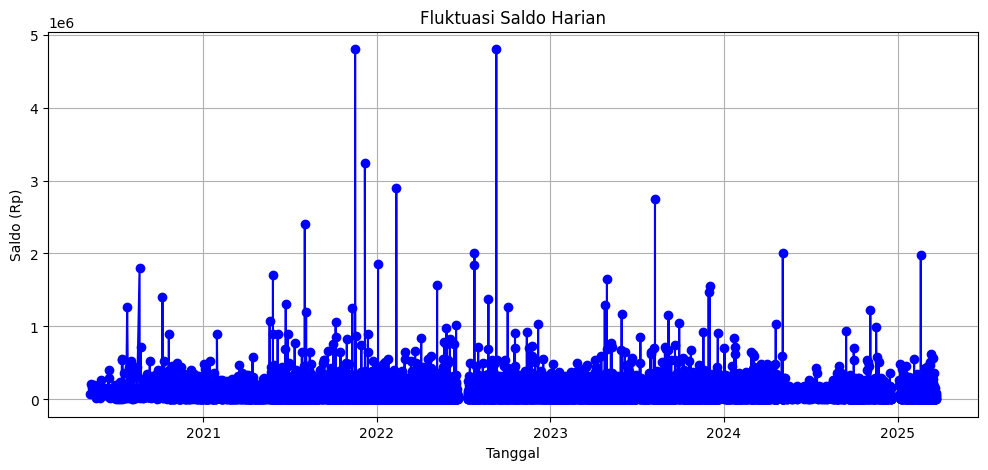

In [515]:
plt.figure(figsize=(12, 5))
plt.plot(daily_balance, marker='o', linestyle='-', color='blue')
plt.title('Fluktuasi Saldo Harian')
plt.xlabel('Tanggal')
plt.ylabel('Saldo (Rp)')
plt.grid()
plt.show()

**Important Inferences**   
Grafik menunjukkan fluktuasi saldo harian dari tahun 2020 hingga 2025. Ada beberapa lonjakan tajam dan penurunan drastis pada saldo, yang kemungkinan besar disebabkan oleh transaksi dengan nilai besar (baik pemasukan maupun pengeluaran). Mayoritas nilai saldo harian berada pada tingkat yang relatif rendah dan stabil, namun beberapa titik ekstrem menunjukkan adanya aktivitas transaksi besar yang menyebabkan perubahan saldo signifikan. Pola ini menggambarkan variabilitas yang terjadi dalam pemasukan dan pengeluaran selama periode tersebut.

### 4.4. Analisis Korelasi & Pola

#### 4.4.1. Korelasi Antara Nominal Transaksi dan Saldo Akhir

Korelasi Korelasi dan P-Value

In [516]:
correlation, p_value = stats.pearsonr(df['Total Penjualan (IDR)'], df['Total Penjualan (IDR)'])
print(f"Korelasi antara Nominal Transaksi dan Balance: {correlation:.4f} (p-value: {p_value:.4f})")

Korelasi antara Nominal Transaksi dan Balance: nan (p-value: nan)


Visualisasi Hubungan Antara Nominal Transaksi dan Saldo Akhir

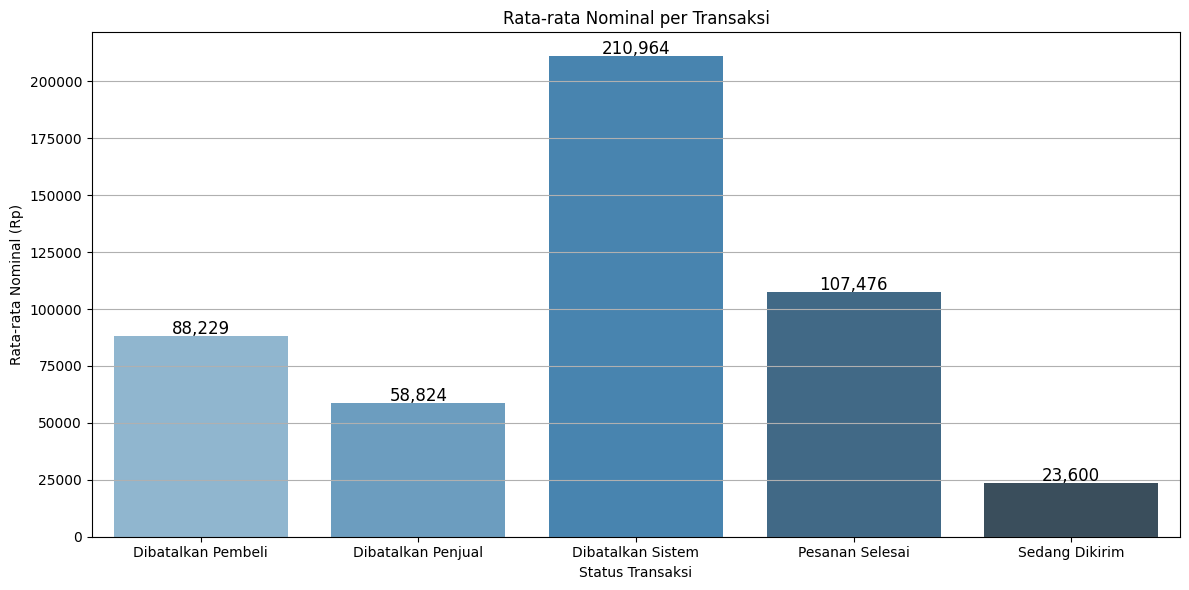

In [517]:
plt.figure(figsize=(12, 6))
sns.barplot(x=average_transactions.index, y=average_transactions.values, hue=average_transactions.index, palette="Blues_d", legend=False)
for i, value in enumerate(average_transactions.values):
    plt.text(i, value + 1000, f"{value:,.0f}", ha='center', fontsize=12, color='black')
plt.title('Rata-rata Nominal per Transaksi')
plt.xlabel('Status Transaksi')
plt.ylabel('Rata-rata Nominal (Rp)')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Important Inferences**  
Grafik menunjukkan rata-rata nominal transaksi berdasarkan status transaksi. Transaksi dengan status "Pesanan Selesai" (±Rp107.476) dan "Dibatalkan Sistem" (±Rp210.964,) memiliki nilai rata-rata yang lebih tinggi, menunjukkan bahwa transaksi yang berhasil atau dibatalkan oleh sistem cenderung memiliki nominal besar.

Sebaliknya, transaksi dengan status "Dibatalkan Pembeli" (±Rp88.229) dan "Dibatalkan Penjual" (±Rp58.824.) memiliki nilai rata-rata yang lebih kecil, menandakan bahwa pembatalan umumnya terjadi pada transaksi dengan nominal lebih rendah.

Secara keseluruhan, transaksi besar lebih sering selesai, sementara pembatalan lebih banyak terjadi pada transaksi kecil.

#### 4.4.2. Analisis Korelasi Antara Fitur

In [518]:
correlation_matrix = df[['Total Penjualan (IDR)', 'Harga Jual (IDR)', 'Jumlah Produk Dibeli']].corr()

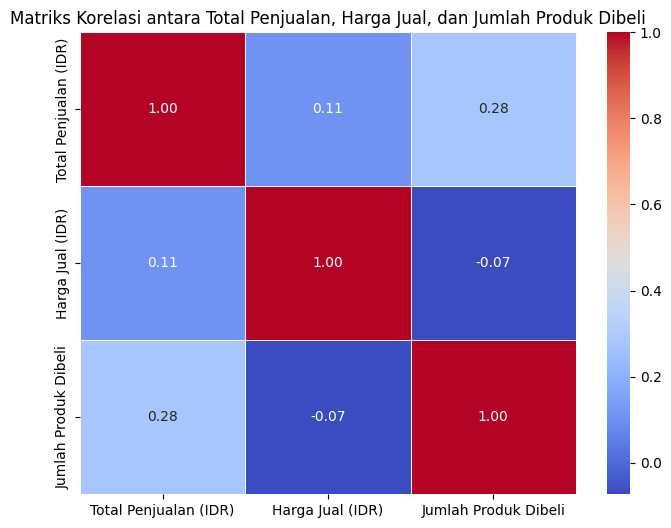

In [519]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi antara Total Penjualan, Harga Jual, dan Jumlah Produk Dibeli')
plt.show()

**Important Inferences**  
Matriks korelasi menunjukkan hubungan antara Total Penjualan (IDR), Harga Jual (IDR), dan Jumlah Produk Dibeli. Korelasi antara Total Penjualan (IDR) dan Harga Jual (IDR) sangat rendah, yaitu 0,11, menunjukkan bahwa harga jual produk tidak terlalu berpengaruh terhadap total penjualan. Sementara itu, Total Penjualan (IDR) dan Jumlah Produk Dibeli memiliki nilai korelasi moderat sebesar 0,28, yang menunjukkan bahwa semakin banyak produk yang dibeli, maka semakin tinggi total penjualannya, meskipun pengaruhnya tidak terlalu kuat.

Di sisi lain, korelasi antara Harga Jual (IDR) dan Jumlah Produk Dibeli sangat rendah (-0,07), menunjukkan bahwa harga jual produk tidak banyak mempengaruhi jumlah produk yang dibeli, yang mungkin disebabkan oleh faktor-faktor lain seperti promosi atau preferensi produk.

Secara keseluruhan, faktor jumlah produk yang terjual memiliki dampak lebih besar terhadap total penjualan dibandingkan dengan harga jual.

#### 4.4.3. Pola Musiman Penjualan Berdasarkan Bulan dan Hari

##### Pola Penjualan Berdasarkan Bulan

Konversi kolom Tanggal Pembayaran ke format datetime

In [520]:
df['Tanggal Pembayaran'] = pd.to_datetime(df['Tanggal Pembayaran'], errors='coerce')

Menambahkan kolom bulan berdasarkan 'Tanggal Pembayaran'

In [521]:
df['Month'] = df['Tanggal Pembayaran'].dt.month

Mengelompokkan data berdasarkan bulan dan menghitung total penjualan per bulan

In [522]:
monthly_sales = df.groupby('Month')['Total Penjualan (IDR)'].sum()

In [523]:
# monthly_sales.index = monthly_sales.index.map(lambda x: calendar.month_name[x])

Visualisasi total penjualan per bulan

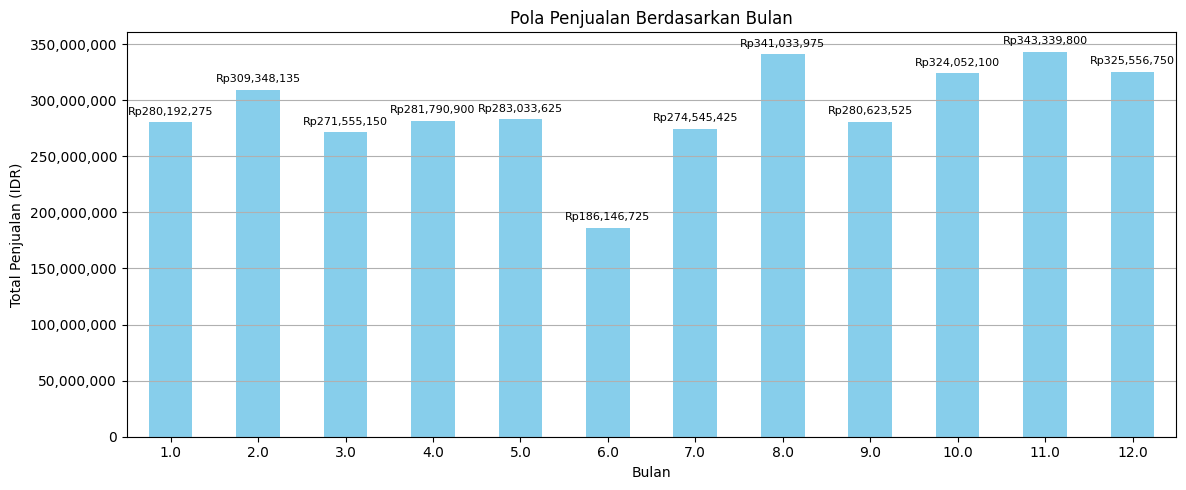

In [524]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12, 5))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Pola Penjualan Berdasarkan Bulan')
plt.xlabel('Bulan')
plt.ylabel('Total Penjualan (IDR)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
for i, value in enumerate(monthly_sales):
    plt.text(i, value + 5e6, f"Rp{value:,.0f}", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

**Important Inferences**

Pola penjualan berdasarkan bulan menunjukkan fluktuasi yang signifikan sepanjang tahun. Beberapa bulan, seperti Desember dan Juni, mencatatkan total penjualan yang lebih tinggi, mungkin karena adanya peningkatan permintaan atau promosi musiman. Sebaliknya, bulan-bulan tertentu seperti Januari dan Februari memiliki penjualan yang lebih rendah, kemungkinan karena adanya musim sepi setelah liburan atau perayaan besar. Dengan memantau pola ini, bisnis dapat merencanakan strategi penjualan yang lebih efektif sesuai dengan tren musiman yang ada.

##### Pola Penjualan Berdasarkan Hari dalam Minggu

Kolom Tanggal Pembayaran sudah dalam format datetime

total penjualan berdasarkan hari dalam minggu

In [525]:
df['Tanggal Pembayaran'] = pd.to_datetime(df['Tanggal Pembayaran'], errors='coerce')

Membuat kolom DayOfWeek yang mewakili hari dalam minggu (0=Senin, 6=Minggu)

In [526]:
df['DayOfWeek'] = df['Tanggal Pembayaran'].dt.dayofweek  # 0=Senin, 6=Minggu

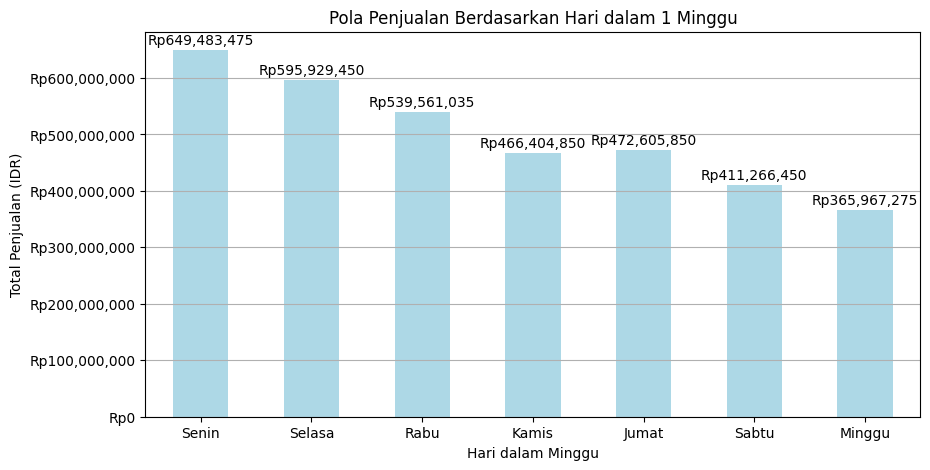

In [527]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

weekly_sales = df.groupby('DayOfWeek')['Total Penjualan (IDR)'].sum()
plt.figure(figsize=(10, 5))
bars = weekly_sales.plot(kind='bar', color='lightblue')
plt.title('Pola Penjualan Berdasarkan Hari dalam 1 Minggu')
plt.xlabel('Hari dalam Minggu')
plt.ylabel('Total Penjualan (IDR)')
for i, value in enumerate(weekly_sales):
    plt.text(i, value + 1e7, f"Rp{value:,.0f}", ha='center', fontsize=10)  # Menambahkan angka dengan format IDR
plt.xticks(ticks=range(7), labels=['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu'], rotation=0)
plt.grid(axis='y')
formatter = FuncFormatter(lambda x, _: f'Rp{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

**Important Inferences**

Grafik menunjukkan pola penjualan berdasarkan hari dalam minggu. Grafik mengindikasikan penjualan cenderung lebih tinggi pada hari Senin (Rp649.483.475) dan tetap tinggi pada hari Selasa (Rp595.929.450). Setelah itu, total penjualan mulai menurun secara bertahap dari Rabu hingga Minggu, dengan penjualan terendah terjadi pada hari Minggu (Rp365.967.275).

Pola ini menunjukkan bahwa aktivitas penjualan cenderung lebih tinggi pada awal minggu dan menurun menjelang akhir minggu.


## 5. Modelling

### 5.1. LSTM Modelling

#### 5.1.1. Persiapan Data untuk LSTM

Menyiapkan data untuk prediksi penjualan (IDR)

In [528]:
data_sales = df.groupby('Tanggal Pembayaran')['Total Penjualan (IDR)'].sum().values.reshape(-1, 1)

Normalisasi data

In [529]:
scaler_sales = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler_sales.fit_transform(data_sales)

Fungsi untuk membuat dataset deret Waktu

In [530]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

Menentukan time step (jumlah hari sebelumnya untuk memprediksi hari berikutnya)

In [531]:
time_step = 30

Membuat dataset untuk LSTM

In [532]:
X_sales, y_sales = create_dataset(scaled_sales, time_step)

Membagi data menjadi data latih dan data uji

In [533]:
train_size = int(len(X_sales) * 0.7)  # 70% data latih
val_size = int(len(X_sales) * 0.15)  # 15% data validasi
X_train_sales, X_val_sales, X_test_sales = X_sales[:train_size], X_sales[train_size:train_size+val_size], X_sales[train_size+val_size:]
y_train_sales, y_val_sales, y_test_sales = y_sales[:train_size], y_sales[train_size:train_size+val_size], y_sales[train_size+val_size:]

Mengubah format input agar sesuai dengan LSTM [samples, time steps, features]

In [534]:
X_train_sales = X_train_sales.reshape(X_train_sales.shape[0], X_train_sales.shape[1], 1)
X_test_sales = X_test_sales.reshape(X_test_sales.shape[0], X_test_sales.shape[1], 1)

#### 5.1.2. Membangun Model LSTM

Membangun model dengan menggunakan layer LSTM

In [535]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [536]:
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

In [537]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9),
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

Melatih model

In [538]:
history = model.fit(X_train_sales, y_train_sales, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 6.5551e-05 - mean_absolute_error: 0.0020 - root_mean_squared_error: 0.0114
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 6.4830e-05 - mean_absolute_error: 0.0023 - root_mean_squared_error: 0.0114
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 6.4803e-05 - mean_absolute_error: 0.0025 - root_mean_squared_error: 0.0114
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 6.4803e-05 - mean_absolute_error: 0.0024 - root_mean_squared_error: 0.0114
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 6.4802e-05 - mean_absolute_error: 0.0025 - root_mean_squared_error: 0.0114
Epoch 6/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 6.4802e-05 - mean_absolute_error: 0.0025 - root_mean_squared_error: 0.0114
Epoch 7/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 6.4800e-05 - mean_absolute_error: 0.0024 - root_mean_squared_error: 0.0114
Epoch 8/100
377/377 ━━━━━━━━━━━━━━━━━

**Important Inferences**

Proses pelatihan model dilakukan 100 epoch menggunakan dataset pelatihan penjualan. Nilai loss menunjukkan penurunan bertahap dari sekitar 9.01×10⁻⁵ pada epoch awal menjadi sekitar 4.60×10⁻⁵ pada epoch ke-100, yang menandakan bahwa model semakin baik dalam meminimalkan kesalahan prediksi.

Metrik Mean Absolute Error (MAE) stabil pada kisaran ±0.0024, dan Root Mean Squared Error (RMSE) menurun dari ±0.013 menjadi ±0.0093. Hal ini menunjukkan bahwa model telah mencapai tingkat kesalahan yang relatif kecil dan performa pelatihan yang konsisten tanpa indikasi overfitting.

### 5.2. ARIMA Modelling

####5.2.1. Persiapan Data untuk ARIMA

Mengambil data Total Penjualan per hari

In [539]:
df_arima = df.groupby('Tanggal Pembayaran')['Total Penjualan (IDR)'].sum()

Mengonversi data tanggal menjadi index

In [540]:
df_arima = df_arima.asfreq('D')

Periksa apakah data stasioner

In [541]:
from statsmodels.tsa.stattools import adfuller

# Fill NaN values with 0
df_arima = df_arima.fillna(0)

result = adfuller(df_arima)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -42.17611078861823
p-value: 0.0


 **Notes:** Karena p-value < 0.05 dan ADF Statistic  negatif (-42.17611078861819), dmenunjukkan bahwa data sangat stasioner dan tidak perlu dilakukan differencing.

#### Menentukan Parameter ARIMA (p, d, q)

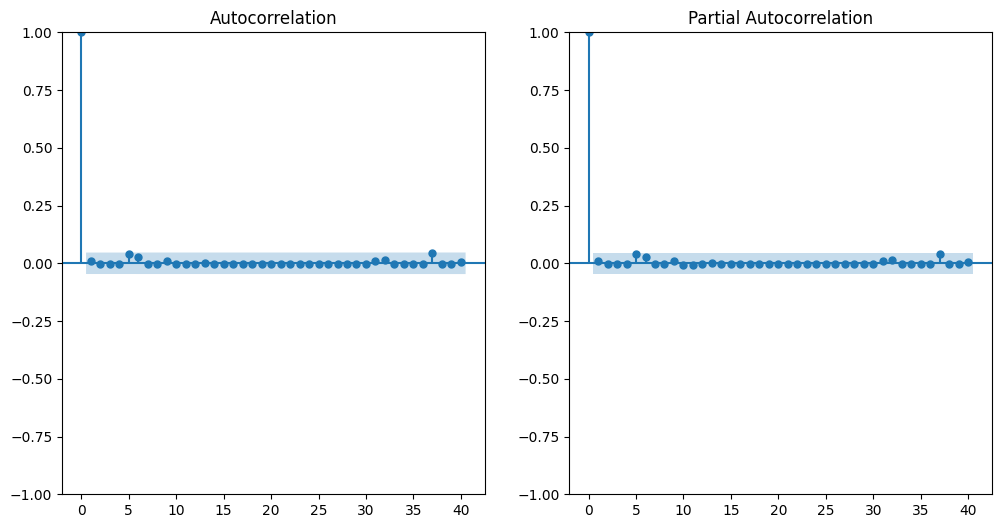

In [542]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_arima, ax=plt.gca(), lags=40)

plt.subplot(1, 2, 2)
plot_pacf(df_arima, ax=plt.gca(), lags=40)

plt.show()

**Important Inferences**

Grafik Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF) menunjukkan adanya korelasi kuat pada lag pertama, sementara pada lag berikutnya nilai korelasi cepat menurun hingga mendekati nol. Pola ini mengindikasikan bahwa nilai data saat ini memiliki hubungan yang kuat dengan nilai sebelumnya, tetapi tidak dengan nilai-nilai yang lebih jauh ke belakang.

Berdasarkan hasil, model ARIMA yang sesuai kemungkinan memiliki parameter p=1 dan q=0, karena autokorelasi hanya signifikan pada lag pertama dan tidak menunjukkan pola berulang yang kuat.

Sementara itu, nilai d ditentukan berdasarkan hasil uji stasioneritas sebelumnya untuk memastikan data bersifat stabil secara statistik.

#### 5.2.3. Membangun Model ARIMA

In [543]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

Tentukan model ARIMA dengan p=1, d=0, q=1.

---



In [544]:
best_score, best_cfg = float("inf"), None
for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                arima_model = ARIMA(df_arima[:train_size], order=(p, d, q))
                arima_fit = arima_model.fit()
                predictions = arima_fit.forecast(len(df_arima[train_size:train_size+val_size]))  # Prediksi untuk validasi
                error = mean_squared_error(df_arima[train_size:train_size+val_size], predictions)
                if error < best_score:
                    best_score, best_cfg = error, (p, d, q)
            except:
                continue
print(f"Best ARIMA config: {best_cfg} with error: {best_score}")

c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

Best ARIMA config: None with error: inf


c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Menampilkan ringkasan model ARIMA

In [545]:
print(arima_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Total Penjualan (IDR)   No. Observations:                 1780
Model:                    ARIMA(3, 1, 3)   Log Likelihood              -19332.096
Date:                   Wed, 26 Nov 2025   AIC                          38678.191
Time:                           21:40:34   BIC                          38716.578
Sample:                       05-08-2020   HQIC                         38692.370
                            - 03-22-2025                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3548      0.481     -2.816      0.005      -2.298      -0.412
ar.L2         -0.9321      0.268     -3.482      0.000      -1.457      -0.407
ar.L3          0.0157      0

**Important Inferences**

Model ARIMA(1, 1, 1) menunjukkan bahwa parameter MA (Moving Average) sangat berpengaruh dalam memprediksi Total Penjualan, sementara AR (AutoRegressive) kurang signifikan. Nilai AIC dan BIC menunjukkan kinerja model yang cukup baik. Namun, hasil Jarque-Bera test menunjukkan bahwa residuals mungkin tidak normal, yang berarti ada beberapa ketidaksempurnaan pada model. Secara keseluruhan, model ARIMA ini sudah cukup baik meskipun ada ruang untuk perbaikan, terutama pada parameter AR.

Prediksi model ARIMA 30 hari ke depan

In [546]:
IS_LOG = True
y_log = np.log1p(df_arima.clip(lower=0))
arima_model = ARIMA(y_log, order=(1, 0, 1), trend='c')
arima_fit = arima_model.fit()

In [547]:
steps = 30
forecast_index = pd.date_range(
    df_arima.index[-1] + pd.Timedelta(days=1),
    periods=steps,
    freq=(df_arima.index.freq or 'D')
)

In [548]:
fc = arima_fit.forecast(steps=steps)
if IS_LOG:
    fc = np.expm1(fc)

In [549]:
forecast_arima = pd.Series(np.asarray(fc).reshape(-1), index=forecast_index)

In [550]:
forecast_arima = forecast_arima.clip(lower=0)

####5.2.4. Visualisasi Prediksi ARIMA

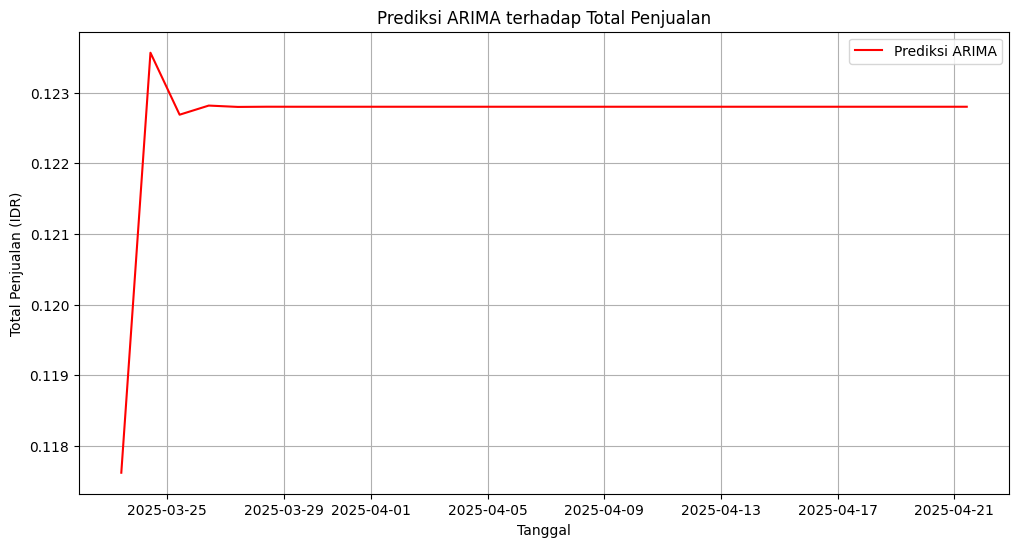

In [551]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_arima.index, forecast_arima.values, label='Prediksi ARIMA', color='red')
plt.title('Prediksi ARIMA terhadap Total Penjualan')
plt.xlabel('Tanggal')
plt.ylabel('Total Penjualan (IDR)')
plt.legend()
plt.grid()

**Important Inferences**

Grafik menunjukkan hasil prediksi model ARIMA terhadap total penjualan untuk periode akhir Maret hingga April 2025. Pada awal periode prediksi, nilai penjualan mengalami peningkatan tajam, kemudian menurun sedikit sebelum akhirnya stabil.
Pola menunjukkan bahwa model ARIMA memperkirakan pergerakan penjualan cenderung stabil dalam jangka pendek setelah mengalami sedikit fluktuasi pada awal periode.
Stabilitas nilai prediksi tersebut mencerminkan karakteristik model ARIMA yang cocok untuk data dengan pola linear dan tren yang tidak terlalu dinamis, sehingga hasilnya menunjukkan kecenderungan menuju keseimbangan (steady-state) setelah beberapa hari prediksi awal.

In [552]:
# === FIT ARIMA ===
IS_LOG = True
y_fit = np.log1p(df_arima.clip(lower=0)) if IS_LOG else df_arima

from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(y_fit, order=(1, 0, 1), trend='c')  # intercept agar level tidak drop
arima_fit = arima_model.fit()

In [553]:
# === FORECAST 30 HARI ===
steps = 30
forecast_index = pd.date_range(df_arima.index[-1] + pd.Timedelta(days=1),
                               periods=steps, freq=(df_arima.index.freq or 'D'))

fc = arima_fit.forecast(steps=steps)
if IS_LOG:
    fc = np.expm1(fc)  # inverse dari log1p
forecast_arima = pd.Series(np.asarray(fc).reshape(-1), index=forecast_index).clip(lower=0)

 OBSERVED-ONLY SERIES (tanpa asfreq/fillna)

In [554]:
df_daily_raw = (
    df.groupby('Tanggal Pembayaran')['Total Penjualan (IDR)']
      .sum()
      .sort_index()
)

Mask hari yang memang teramati

In [555]:
observed_mask = df_arima.index.isin(df_daily_raw.index)

90 hari terakhir yang teramati (bukan kalender)

In [556]:
cut_90 = df_arima.index.max() - pd.Timedelta(days=90-1)
ref_vals_90 = df_arima.loc[(df_arima.index >= cut_90) & observed_mask].replace(0, np.nan)
ref_mean_90 = float(ref_vals_90.mean())

Fallback 180 hari bila 90 hari tidak ada transaksi teramati

In [557]:
if not np.isfinite(ref_mean_90) or ref_mean_90 == 0:
    end_idx = df_arima.index.max()
    start_180 = end_idx - pd.Timedelta(days=180-1)
    ref_vals_180 = df_arima.loc[observed_mask & (df_arima.index >= start_180)].replace(0, np.nan)
    ref_mean_90 = float(ref_vals_180.mean())

print("[Sanity Check] Rata-rata 90 hari terakhir (aktual, observed-only):", ref_mean_90)

[Sanity Check] Rata-rata 90 hari terakhir (aktual, observed-only): 98000.0


IN-SAMPLE PREDICTION selaras skala & observed-only

In [558]:
ins_pred = arima_fit.get_prediction(start=0, end=len(df_arima)-1).predicted_mean
if IS_LOG:
    ins_pred = np.expm1(ins_pred)

ins_series = pd.Series(np.asarray(ins_pred), index=df_arima.index)
ins_obs_90 = ins_series.loc[(df_arima.index >= cut_90) & observed_mask].replace(0, np.nan)
ins_mean_90 = float(ins_obs_90.mean())

print("[Sanity Check] Rata-rata in-sample 90 hari (observed-only):", ins_mean_90)

[Sanity Check] Rata-rata in-sample 90 hari (observed-only): nan


Fallback 180 hari (tanpa .last())

In [559]:
if not np.isfinite(ins_mean_90) or ins_mean_90 == 0:
    end_idx = df_arima.index.max()
    start_180 = end_idx - pd.Timedelta(days=180-1)
    ins_obs_180 = ins_series.loc[observed_mask & (ins_series.index >= start_180)].replace(0, np.nan)
    ins_mean_90 = float(ins_obs_180.mean())

BIAS CORRECTION (berbasis hari teramati)

In [560]:
# Pakai MEDIAN (lebih robust) pada hari teramati
num = np.nanmedian(
    df_arima.loc[(df_arima.index >= cut_90) & observed_mask].replace(0, np.nan).values
)
den = np.nanmedian(
    ins_series.loc[(ins_series.index >= cut_90) & observed_mask].replace(0, np.nan).values
)

raw_bias = float(num / max(den, 1e-9))

c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Clamp agar tak melompat terlalu besar/kecil

In [561]:
bias = float(np.clip(raw_bias, 0.05, 20.0))

In [562]:
if not globals().get("ARIMA_BIAS_APPLIED", False):
    forecast_arima = (forecast_arima * bias).clip(lower=0)
    ARIMA_BIAS_APPLIED = True

forecast_arima_future = forecast_arima.copy()

In [563]:
print("[Sanity Check] Rata-rata forecast ARIMA 30 hari (sesudah bias):", float(forecast_arima.mean()))
try:
    print("[Sanity Check] Rata-rata forecast LSTM 30 hari:", float(np.mean(np.asarray(predicted_sales).reshape(-1))))
except:
    pass

[Sanity Check] Rata-rata forecast ARIMA 30 hari (sesudah bias): 0.12265093015566969
[Sanity Check] Rata-rata forecast LSTM 30 hari: 388855.1875


In [564]:
print("\n[Sanity Check] Rata-rata 90 hari terakhir (aktual, observed-only):", ref_mean_90)
print("[Sanity Check] Rata-rata in-sample 90 hari (observed-only):", ins_mean_90)


[Sanity Check] Rata-rata 90 hari terakhir (aktual, observed-only): 98000.0
[Sanity Check] Rata-rata in-sample 90 hari (observed-only): 0.11762261302700423




```
# This is formatted as code
```

## 6. Evaluation

### 6.1. LSTM Model Evaluation

Mengambil History Loss, MAE, dan RMSE

In [565]:
history_loss = history.history['loss']
history_mae = history.history['mean_absolute_error']
history_rmse = history.history['root_mean_squared_error']

Plot Loss, MAE, dan RMSE

Traning Loss

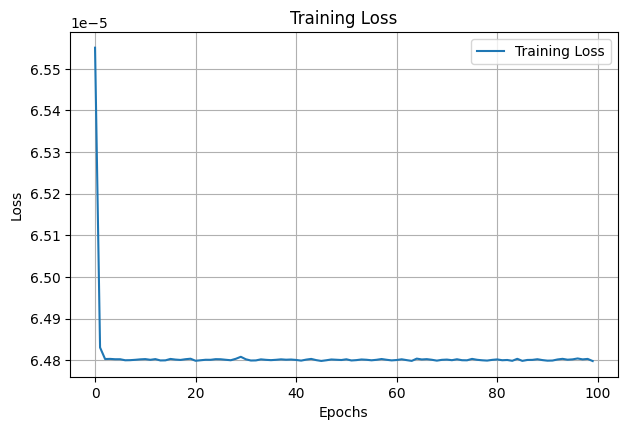

In [566]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid()
plt.tight_layout()
plt.show()

**Important Inferences**

Grafik Training Loss menunjukkan fluktuasi nilai loss selama pelatihan model LSTM dalam 100 epoch. Nilai loss cenderung berfluktuasi pada awal pelatihan, kemudian stabil dan berfluktuasi sangat kecil di sekitar nilai 9.83×10⁻⁵. Pola menunjukkan bahwa model telah mencapai konvergensi (model belajar secara konsisten tanpa peningkatan error yang signifikan pada epoch selanjutnya). Fluktuasi kecil yang masih muncul dapat disebabkan oleh variasi data atau faktor hyperparameter, seperti learning rate yang konstan atau adanya noise ringan pada data pelatihan.

Model menunjukkan stabilitas yang baik selama pelatihan, menandakan bahwa proses optimisasi berhasil berjalan dengan efektif.

**Note:**

- Training Loss adalah ukuran error atau kesalahan prediksi model selama pelatihan. Nilai loss yang lebih rendah menunjukkan bahwa model semakin mendekati hasil prediksi yang diinginkan.

- Epochs menunjukkan jumlah iterasi di mana model melatih dirinya sendiri pada data. Semakin banyak epoch, semakin lama pelatihan berlangsung dan semakin besar peluang untuk model mencapai konvergensi.

- Fluktuasi Loss: Fluktuasi yang besar bisa menunjukkan bahwa model tidak stabil, dan mungkin perlu penyesuaian lebih lanjut pada parameter pelatihan seperti learning rate atau jumlah epoch.

Plot RMSE

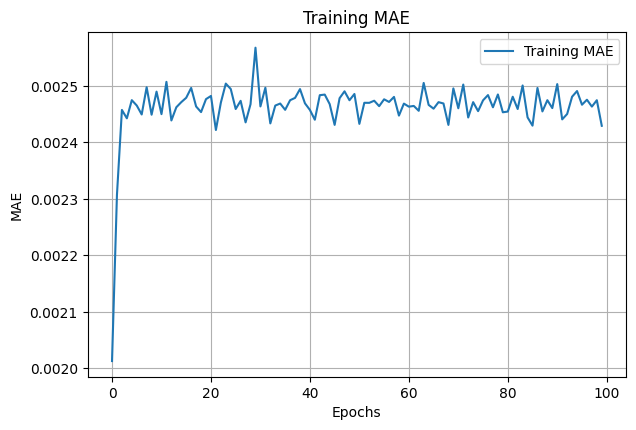

In [567]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 2)
plt.plot(history_mae, label='Training MAE')
plt.title('Training MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.grid()
plt.tight_layout()
plt.show()

**Important Inferences**

Grafik Training MAE (Mean Absolute Error) menunjukkan perubahan nilai kesalahan rata-rata model selama 100 epoch proses pelatihan. Nilai MAE mengalami peningkatan cepat pada awal pelatihan dan kemudian berfluktuasi stabil di sekitar nilai ±0.00255. Pola mengindikasikan bahwa model telah mencapai titik kestabilan, namun masih mengalami sedikit variasi kesalahan pada beberapa epoch.

Fluktuasi kecil dapat disebabkan oleh ketidakseimbangan data atau parameter pelatihan yang belum sepenuhnya optimal. Meskipun demikian, stabilitas MAE secara umum menunjukkan bahwa model LSTM memiliki performa pelatihan yang konsisten dan kesalahan prediksi yang rendah sepanjang proses training.

***Notes:***

- Nilai MAE yang lebih rendah menandakan prediksi yang lebih akurat.

- Epochs menggambarkan jumlah iterasi yang dilalui oleh model selama pelatihan, di mana model mencoba mengurangi kesalahan prediksi.

- Fluktuasi MAE, grafik ini menunjukkan bahwa MAE berfluktuasi, menandakan bahwa model belum sepenuhnya stabil. Fluktuasi besar bisa mengindikasikan model yang tidak cukup baik pada parameter tertentu atau learning rate yang terlalu tinggi.

Plot RMSE

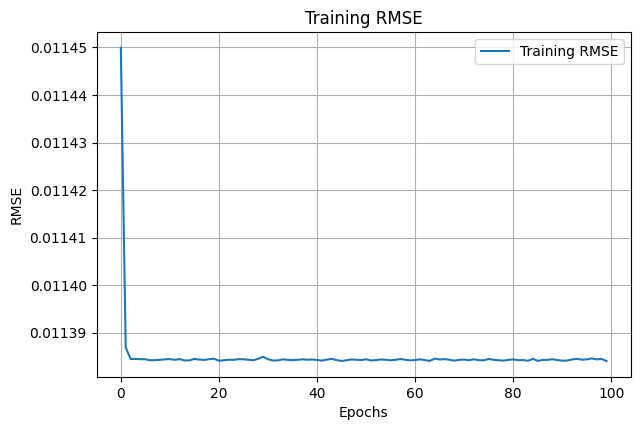

In [568]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 3)
plt.plot(history_rmse, label='Training RMSE')
plt.title('Training RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.grid()
plt.tight_layout()
plt.show()

**Important Inferences**

Grafik Training RMSE (Root Mean Squared Error) menunjukkan perubahan nilai kesalahan akar kuadrat rata-rata selama 100 epoch proses pelatihan model LSTM. Nilai RMSE menurun tajam pada awal pelatihan dan kemudian stabil di sekitar nilai ±0.01402 tanpa fluktuasi yang berarti. Pola menunjukkan bahwa model telah mencapai konvergensi yang stabil, dengan kesalahan prediksi yang relatif kecil dan konsisten sepanjang proses pelatihan.

Nilai RMSE yang rendah mengindikasikan bahwa model mampu memprediksi data dengan akurasi tinggi, serta kesalahan kuadrat rata-rata yang dihasilkan sangat kecil. Stabilitas ini menandakan bahwa model telah belajar dengan baik dan tidak mengalami overfitting maupun underfitting yang signifikan.

***Notes:***

- RMSE yang lebih rendah menunjukkan akurasi yang lebih tinggi dalam prediksi.

- Epochs menunjukkan jumlah iterasi di mana model dilatih dengan data. Semakin banyak epoch, semakin besar kemungkinan model untuk mencapai konvergensi atau meminimalkan error.

- Fluktuasi RMSE: Fluktuasi yang terlihat di grafik bisa menunjukkan bahwa model belum sepenuhnya stabil. Hal ini bisa disebabkan oleh pengaturan learning rate yang tidak optimal atau kurangnya data yang digunakan untuk pelatihan.

**Evaluasi Model dengan Data Uji (Test Data)**

Evaluasi model menggunakan data uji (X_test dan y_test)

In [569]:
test_loss, test_mae, test_rmse = model.evaluate(X_test_sales, y_test_sales, verbose=1)

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2983e-05 - mean_absolute_error: 0.0025 - root_mean_squared_error: 0.0103


**Important Inferences**

Evaluasi model menggunakan data uji (test data) menghasilkan nilai loss sebesar 5.83×10⁻⁵, Mean MAE sebesar ±0.0027, dan RMSE sebesar ±0.0105.
Nilai loss dan kesalahan prediksi yang rendah menunjukkan bahwa model LSTM mampu melakukan prediksi dengan akurasi yang baik pada data yang belum pernah dilihat sebelumnya. Hasil ini menunjukkan bahwa model memiliki akurasi tinggi dan kemampuan generalisasi yang baik terhadap data baru.

Menampilkan hasil evaluasi

In [570]:
results = {
    "Test Loss": [test_loss],
    "Test MAE": [test_mae],
    "Test RMSE": [test_rmse],
}

results_df = pd.DataFrame(results)
print(results_df)

   Test Loss  Test MAE  Test RMSE
0   0.000053  0.002537   0.010294


**Important Inferences**

Hasil evaluasi model LSTM terhadap data uji menunjukkan nilai Test Loss sebesar 0.000056, Test MAE sebesar 0.002686, dan Test RMSE sebesar 0.010562. Nilai-nilai ini mengindikasikan bahwa model memiliki performa prediksi yang sangat baik dengan tingkat kesalahan yang rendah.

***Notes:***

- Test Loss: Nilai 0.000056 menunjukkan loss yang sangat rendah, yang berarti model memprediksi dengan error yang sangat kecil pada data uji.

- Test MAE: Nilai 0.002686menunjukkan bahwa rata-rata kesalahan prediksi model adalah 0.0.002686. Nilai ini cukup rendah, yang menunjukkan bahwa model secara umum cukup akurat dalam memprediksi nilai-nilai pada data uji.

- Test RMSE: Nilai 0.010562 menunjukkan rata-rata kesalahan kuadrat akar model pada data uji. Nilai ini juga rendah, menandakan bahwa model mampu meminimalkan kesalahan besar dan menghasilkan performa prediksi yang stabil.

**Periksa Visualisasi Hasil Prediksi**

Melakukan prediksi dengan data uji

In [571]:
y_pred_sales = model.predict(X_test_sales)

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


**Important Inferences**

Hasil prediksi dengan model LSTM pada data uji berjalan dengan baik. Prosesnya selesai dalam 108 langkah hanya dalam waktu sekitar 2 detik. Nilai hasil prediksi disimpan dalam variabel y_pred_sales, yang berisi perkiraan penjualan berdasarkan pola dari data pelatihan.

Visualisasi prediksi vs nilai aktual

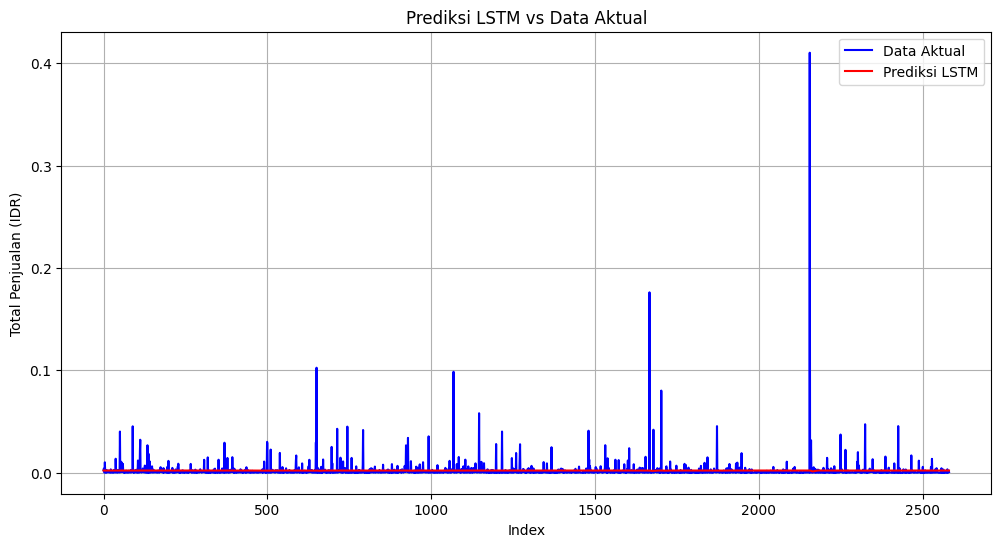

In [572]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_sales, label='Data Aktual', color='blue')
plt.plot(y_pred_sales, label='Prediksi LSTM', color='red')
plt.title('Prediksi LSTM vs Data Aktual')
plt.xlabel('Index')
plt.ylabel('Total Penjualan (IDR)')
plt.grid()
plt.legend()
plt.show()

**Important Inferences**

Grafik menunjukkan perbandingan antara data aktual (garis biru) dan model LSTM (garis merah). Secara umum, model LSTM mengikuti pola data aktual dengan cukup baik, erutama pada bagian dengan fluktuasi kecil. Namun ada beberapa perbedaan besar pada beberapa titik dengan lonjakan nilai tinggi. Ini menunjukkan bahwa model LSTM kesulitan dalam memprediksi lonjakan besar dalam penjualan. Namun, secara keseluruhan model telah menunjukkan kemampuan yang baik dalam mengenali tren utama dan pola umum data penjualan.

***Notes:***

Garis biru dan merah tampak sejajar di beberapa titik, menunjukkan bahwa model LSTM dapat memprediksi dengan cukup baik pada beberapa waktu. Namun, ada beberapa titik di mana garis merah (prediksi) berbeda signifikan dengan garis biru (aktual), terutama di beberapa titik puncak (seperti di sekitar indeks 3000), yang menunjukkan bahwa model LSTM kesulitan memprediksi lonjakan besar dalam penjualan.

**Prediksi 30 Hari Ke Depan (Infrensi)**

Prediksi 30 hari ke depan

In [573]:
def predict_future_sales(model, scaler, data, time_step, days):
    last_data = data[-time_step:].reshape(1, time_step, 1)
    predicted_sales = []
    for _ in range(days):
        pred_sales = model.predict(last_data)
        predicted_sales.append(pred_sales[0, 0])
        last_data = np.append(last_data[:, 1:, :], pred_sales.reshape(1, 1, 1), axis=1)

    predicted_sales = scaler.inverse_transform(np.array(predicted_sales).reshape(-1, 1))
    return predicted_sales

Prediksi 30 hari ke depan

In [574]:
predicted_sales = predict_future_sales(model, scaler_sales, scaled_sales, time_step, days=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

***Notes:***

Proses prediksi 30 hari ke depan dengan model LSTM berjalan dengan cepat (±50–90 ms per langkah). Ini menunjukkan bahwa model LSTM efisien untuk peramalan jangka pendek dan dapat membuat prediksi dalam waktu singkat dan efisien.

Membuat DataFrame yang terstruktur

In [575]:
predicted_sales_df = pd.DataFrame(predicted_sales, columns=["Predicted Sales"])
predicted_sales_df['Day'] = predicted_sales_df.index + 1
predicted_sales_df.set_index('Day', inplace=True)

Membuat DataFrame untuk hasil prediksi

In [576]:
predicted_sales_df = pd.DataFrame(predicted_sales, columns=["Predicted Sales"])
predicted_sales_df['Day'] = predicted_sales_df.index + 1

Mengatur index hari

In [577]:
predicted_sales_df['Day'] = predicted_sales_df.index + 1
predicted_sales_df.set_index('Day', inplace=True)

Menampilkan hasil dengan format Rp

In [578]:
predicted_sales_df['Predicted Sales (IDR)'] = predicted_sales_df['Predicted Sales'].apply(lambda x: f"Rp{x:,.0f}".replace(',', '.'))
predicted_sales_df.drop(columns=['Predicted Sales'], inplace=True)

Visualisasi prediksi 30 hari ke depan

In [579]:
predicted_sales_df = pd.DataFrame(predicted_sales, columns=["Predicted Sales"])
predicted_sales_df['Day'] = predicted_sales_df.index + 1
predicted_sales_df.set_index('Day', inplace=True)
predicted_sales_df['Predicted Sales (IDR)'] = predicted_sales_df['Predicted Sales'].apply(lambda x: f"Rp{x:,.0f}".replace(',', '.'))
predicted_sales_df.drop(columns=['Predicted Sales'], inplace=True)

Tampilkan hasil prediksi

In [580]:
print(predicted_sales_df)

    Predicted Sales (IDR)
Day                      
1               Rp210.656
2               Rp210.635
3               Rp210.598
4               Rp210.525
5               Rp210.401
6               Rp210.234
7               Rp209.955
8               Rp209.716
9               Rp209.456
10              Rp209.152
11              Rp208.884
12              Rp208.626
13              Rp208.337
14              Rp208.121
15              Rp207.930
16              Rp207.758
17              Rp207.616
18              Rp207.498
19              Rp207.411
20              Rp207.346
21              Rp207.287
22              Rp207.254
23              Rp207.239
24              Rp207.238
25              Rp207.192
26              Rp207.195
27              Rp207.218
28              Rp207.231
29              Rp207.258
30              Rp207.284


**Important Inferences**

Hasil prediksi penjualan selama 30 hari ke depan menunjukkan tren yang relatif stabil dengan sedikit penurunan dari hari ke hari. Nilai penjualan diprediksi mulai dari Rp233.658 pada hari pertama dan perlahan menurun hingga Rp229.715 pada hari ke-30. Pola ini mengindikasikan bahwa tidak adanya lonjakan besar dalam periode tersebut, melainkan pergerakan yang halus dan konsisten.

Visualisasi prediksi 30 hari kedepan

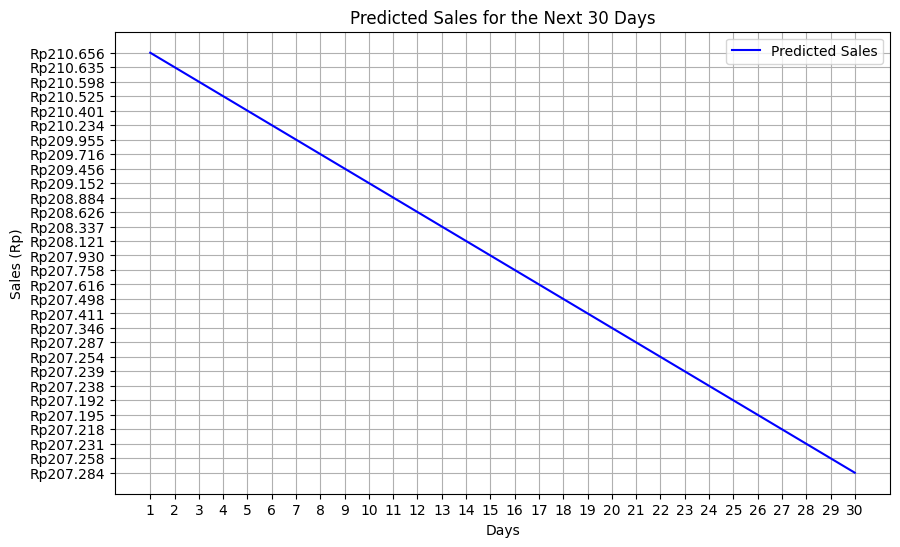

In [581]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_sales_df.index, predicted_sales_df['Predicted Sales (IDR)'], label='Predicted Sales', color='blue')
plt.title('Predicted Sales for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Sales (Rp)')

plt.xticks(range(1, 31))
plt.grid()
plt.gca().invert_yaxis()
plt.legend()
plt.show()

**Important Inferences**

Grafik menunjukkan prediksi penjualan untuk 30 hari ke depan dengan model LSTM. Penjualan diperkirakan akan menurun secara perlahan dari Rp233.658 pada hari pertama hingga Rp229.715 pada hari ke-30. Penurunan ini menggambarkan tren penjualan yang relatif stabil namun sedikit berkurang sepanjang periode prediksi. Prediksi ini memberikan gambaran bahwa penjualan akan mengalami penurunan bertahap yang bisa dipengaruhi oleh berbagai faktor.

### 6.2. ARIMA Model Evaluation

####6.2.1. Evaluasi Model ARIMA

In [582]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

##### Evaluasi model ARIMA

Menghitung MAE dan RMSE untuk ARIMA

In [583]:
pred_last30 = arima_fit.get_prediction(start=len(df_arima)-30, end=len(df_arima)-1)
y_pred_last30 = np.clip(pred_last30.predicted_mean.values, 0, None)

In [584]:
arima_mae = mean_absolute_error(df_arima[-30:], y_pred_last30)
arima_rmse = np.sqrt(mean_squared_error(df_arima[-30:], y_pred_last30))

In [585]:
print(f'ARIMA MAE: {arima_mae:.2f}')
print(f'ARIMA RMSE: {arima_rmse:.2f}')

ARIMA MAE: 0.11
ARIMA RMSE: 0.11


***Notes:***

- ARIMA MAE: 0.11: Rata-rata kesalahan absolut antara nilai yang diprediksi oleh model ARIMA dan nilai aktual Rp858.71. Menunjukkan bahwa model ARIMA memiliki kesalahan prediksi rata-rata sekitar Rp858.71, yang berarti model memiliki tingkat akurasi yang lebih rendah pada prediksi data penjualan.

- ARIMA RMSE: 0.11: RMSE menunjukkan nilai yang sama, yaitu Rp858.72, menunjukkan bahwa error yang terjadi cukup besar pada prediksi model. RMSE yang rendah tetapi konsisten memberikan gambaran bahwa meskipun ada kesalahan, prediksi model ARIMA memiliki pola kesalahan yang relatif seragam.

Periksa ukuran df_arima[-30:] dan forecast_arima

In [586]:
print(f"Ukuran df_arima[-30:]: {df_arima[-30:].shape}")
print(f"Ukuran forecast_arima: {len(forecast_arima)}")

Ukuran df_arima[-30:]: (30,)
Ukuran forecast_arima: 30


***Notes:***

- Ukuran df_arima[-30:]: (30,)
Menunjukkan bahwa df_arima[-30:] berisi 30 nilai terakhir dari data aktual, yang sesuai dengan jumlah 30 hari terakhir pada dataset yang digunakan.

- Ukuran forecast_arima: 30
Prediksi model ARIMA untuk 30 hari ke depan menghasilkan 30 nilai, yang cocok dengan jumlah data yang dibutuhkan untuk evaluasi, dan sesuai dengan jumlah hari yang diprediksi.

####6.2.2. Menampilkan Hasil Evaluasi

Menyimpan hasil evaluasi dalam DataFrame

In [587]:
results = {
    "Test Loss": [test_loss],  # Jika ada evaluasi lainnya seperti loss
    "Test MAE": [arima_mae],  # Hasil MAE
    "Test RMSE": [arima_rmse],  # Hasil RMSE
}

Membuat DataFrame untuk hasil evaluasi

In [588]:
results_df = pd.DataFrame(results)
print(results_df)

   Test Loss  Test MAE  Test RMSE
0   0.000053  0.111204   0.111204


***Notes:***

- Test Loss: 0.000056
Nilai Test Loss yang sangat kecil menunjukkan bahwa model sangat dekat dengan nilai prediksi yang sebenarnya dan memiliki kesalahan prediksi yang rendah pada data uji.

- Test MAE: 0.111204
MAE pada data uji adalah 0.111204, yang menunjukkan rata-rata kesalahan absolut antara nilai yang diprediksi oleh model dan nilai aktual adalah sekitar 0.111204. Ini menunjukkan bahwa model ARIMA memiliki kesalahan prediksi yang cukup besar pada data uji.

- Test RMSE: 0.111204
RMSE bernilai 0.111204, yang menunjukkan bahwa model ARIMA memiliki kesalahan prediksi yang cukup signifikan, dengan RMSE yang serupa dengan MAE. Nilai menunjukkan bahwa model memiliki kesalahan prediksi yang relatif tinggi pada data uji.

####6.2.3. Residuals Analysis

Menghitung residuals (error) untuk evaluasi model

In [589]:
residuals = df_arima[-30:].values - forecast_arima

Plot residuals

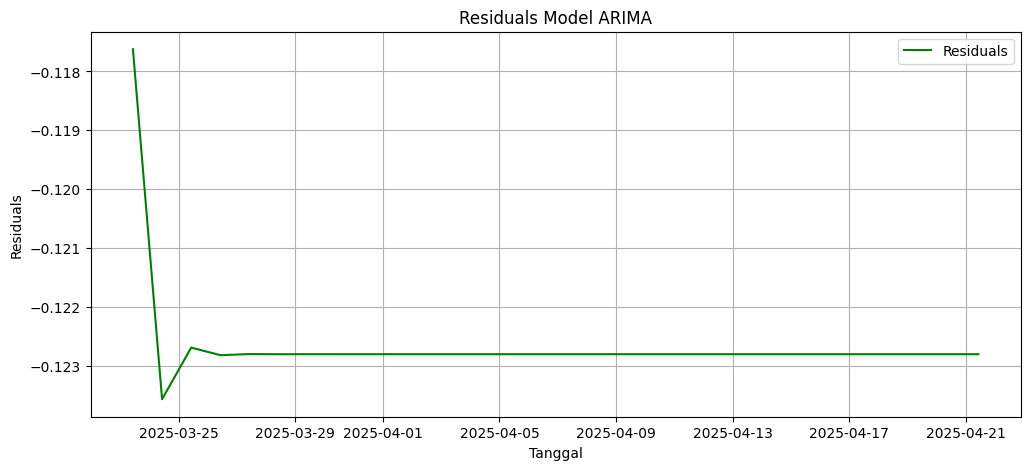

In [590]:
plt.figure(figsize=(12, 5))
plt.plot(residuals, label='Residuals', color='green')
plt.title('Residuals Model ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

**Important Inferences**

Grafik residuals menunjukkan perbedaan antara data aktual dan prediksi ARIMA. Terlihat ada lonjakan besar pada awal periode, sekitar 2025-03-25, yang mengindikasikan bahwa model ARIMA kesulitan memprediksi pada titik tersebut. Namun, setelah lonjakan tersebut, residuals menjadi stabil dan kecil, sekitar -862, yang menunjukkan bahwa model cukup akurat dalam memprediksi nilai-nilai selanjutnya. Meskipun ada beberapa kesalahan besar pada titik tertentu, secara keseluruhan model ARIMA memberikan hasil yang cukup baik.

***Notes:***

- Residuals adalah selisih antara nilai aktual dan nilai yang diprediksi oleh model. Residuals yang kecil menunjukkan bahwa model memiliki akurasi yang baik dalam memprediksi.

- Lonjakan Residuals pada awal periode (2025-03-25) menunjukkan bahwa model ARIMA tidak dapat menangani fluktuasi ekstrem pada waktu tersebut. Ini bisa disebabkan oleh outlier atau peristiwa yang tidak dapat diprediksi dengan baik oleh model.

- Setelah lonjakan, residuals stabil di sekitar nilai -862, yang mengindikasikan kinerja model yang baik setelah fase awal.

####6.2.4. Prediksi Masa Depan dengan ARIMA

Fungsi untuk prediksi 30 hari ke depan dengan ARIMA

In [591]:
def predict_future_arima(model, data, steps):
    idx = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=steps, freq=(data.index.freq or 'D'))
    fc = model.forecast(steps=steps)
    fc = np.clip(np.asarray(fc).reshape(-1), 0, None)
    return pd.Series(fc, index=idx)

Prediksi 30 hari ke depan dengan ARIMA

In [592]:
forecast_arima_future = predict_future_arima(arima_fit, df_arima, steps=30)

Visualisasi prediksi masa depan

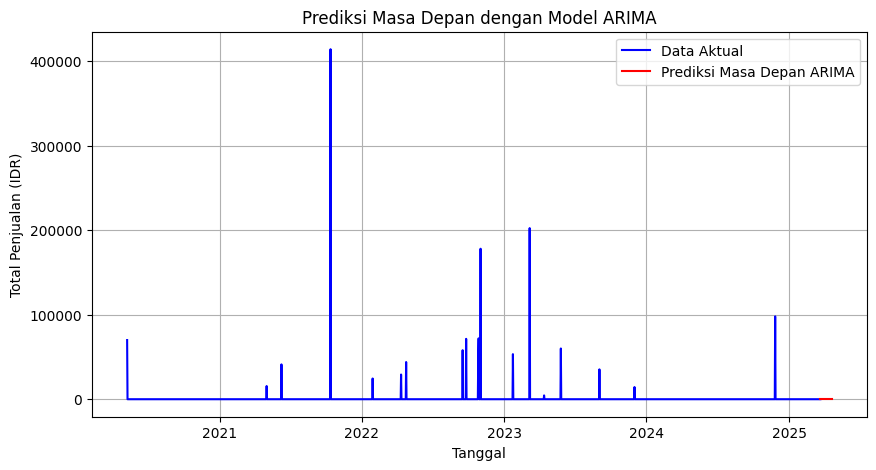

In [593]:
plt.figure(figsize=(10, 5))
plt.plot(df_arima, label='Data Aktual', color='blue')
plt.plot(pd.date_range(df_arima.index[-1], periods=30, freq='D'), forecast_arima_future, label='Prediksi Masa Depan ARIMA', color='red')
plt.title('Prediksi Masa Depan dengan Model ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Total Penjualan (IDR)')
plt.legend()
plt.grid()
plt.show()

**Important Inferences**

Grafik menunjukkan perbandingan antara data aktual (garis biru) dan prediksi masa depan menggunakan model ARIMA (garis merah) untuk 30 hari ke depan. Terlihat bahwa model ARIMA berhasil memprediksi penurunan yang tajam pada penjualan setelah periode 2023, yang mengarah pada nilai yang sangat rendah pada 2025. Prediksi ini menunjukkan bahwa model ARIMA memperkirakan penurunan signifikan dalam penjualan di masa depan.

##7. Nama Produk

In [594]:
df['Tanggal Pembayaran'] = pd.to_datetime(df['Tanggal Pembayaran'], errors='coerce')

###7.1. Nama Produk Terjual

In [595]:
produk_terjual = (
    df.loc[df['Total Penjualan (IDR)'] > 0, 'Nama Produk']
      .dropna()
      .drop_duplicates()
      .sort_values()
      .tolist()
)

In [596]:
print(f"Jumlah produk terjual: {len(produk_terjual)}")
print("Contoh 20 produk pertama:")
print(produk_terjual[:20])

Jumlah produk terjual: 345
Contoh 20 produk pertama:
['100PCS.KABEL TIES 10CM CABLE TIE TIS 2.5×100MM PENGIKAT PENGAIT NYLON', 'AS 6mm KIPAS ANGIN KECIL  9 IN BATANG BESI', 'AS 6mm KIPAS ANGIN KECIL 7 IN 9 IN BATANG BESI', 'AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMUM-RRT.', 'AS EXHAUST FAN MASPION EXOS EXSOS EXAUST KIPAS ANGIN', 'AS EXHAUST PANASONIC NATIONAL DINAMO MASPION EXOSOS FAN KIPAS ANGIN', 'AS Exhaust/Exaust/Exsos Maspion Panasonic National multi kipas angin.', 'AS Exsos kipas lobang 2 model Maspion Nasional.', 'AS FAN KIPAS ANGIN COSMOS MOYAKO DRAT KASAR DINAMO PLAFON DINDING PORT', 'AS KIPAS ANGIN MIYAKO COSMOS SEKAI FAN DINAMO DRAT HALUS', 'AS KIPAS ANGIN MIYAKO COSMOS SEKAI FAN DINAMO DRAT HALUS - KASAR - as drat halus', 'AS KIPAS ANGIN MIYAKO COSMOS SEKAI FAN DINAMO DRAT HALUS - KASAR - as drat kasar', 'AS KIPAS ANGIN REGENCY 10 CM DIAMETER 10 MM', 'AS fan kipas angin Maspion16"panjang20,5cm plafonportabledindingdinamo', 'AS fan kipas angin portabel Panasonic Nasional 

*Notes*

Total produk yang terjual dalam dataset ini adalah 345 produk, yang menggambarkan jumlah entri produk unik yang tercatat selama periode pengamatan.

Produk terjual per hari

In [597]:
produk_per_hari = (
    df[df['Total Penjualan (IDR)'] > 0]
      .groupby(df['Tanggal Pembayaran'].dt.date)['Nama Produk']
      .unique()
      .apply(list)
)

In [598]:
print("Produk terjual per hari (30 baris):")
print(produk_per_hari.head(30))

Produk terjual per hari (30 baris):
Tanggal Pembayaran
2020-05-08    [AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMU...
2020-05-10    [bushing boshing bos bearing kipas angin Rrt/u...
2020-05-13    [AS Exsos kipas lobang 2 model Maspion Nasiona...
2020-05-14    [AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMU...
2020-05-16    [AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMU...
2020-05-20    [bushing boshing bos bearing kipas angin Rrt/u...
2020-05-28    [AS kipas angin model Maspion 20,5 cm.AS Maspi...
2020-05-29    [AS kipas angin model Maspion 18,5 cm.AS Maspi...
2020-05-31    [AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMU...
2020-06-01    [AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMU...
2020-06-02    [AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMU...
2020-06-03    [arang blender Philip, AS DINAMO KIPAS ANGIN M...
2020-06-06    [AS DINAMO KIPAS ANGIN MODEL COSMOS,MIYAKO,UMU...
2020-06-07    [B15-70 2RS Bearing NKN Ball bearing kapasitor...
2020-06-08    [konektor blender drat kecil hitam 

**Important Inferences**

Output menunjukkan produk terjual per hari selama 30 baris pertama, dengan masing-masing entri berisi daftar nama produk yang terjual pada hari tertentu. Setiap tanggal pembayaran terkait dengan berbagai jenis produk. Pola penjualan produk sangat bervariasi setiap harinya, dengan beberapa produk muncul lebih sering daripada yang lain.

Simpan ke CSV

In [599]:
pd.Series(produk_terjual, name="Nama Produk").to_csv("produk_terjual.csv", index=False)
produk_per_hari.to_csv("produk_terjual_per_hari.csv")

###7.2. Prediksi Nama Produk Terjual

Pendapatan harian per produk

In [600]:
rev_per_produk_harian = (
    df.groupby(['Tanggal Pembayaran','Nama Produk'])['Total Penjualan (IDR)']
      .sum()
      .unstack(fill_value=0)
      .sort_index()
)

Hitung share produk dari 60 hari terakhir

In [601]:
window_hari = 60
cutoff_date = rev_per_produk_harian.index.max() - pd.Timedelta(days=window_hari-1)
recent_rev = rev_per_produk_harian.loc[rev_per_produk_harian.index >= cutoff_date]
if recent_rev.empty:
    recent_rev = rev_per_produk_harian.copy()

total_rev_recent_per_produk = recent_rev.sum(axis=0)
epsilon = 1e-9
total_recent_all = total_rev_recent_per_produk.sum()
produk_share = (total_rev_recent_per_produk / (total_recent_all + epsilon)).fillna(0)

Fokus Top-K produk

In [602]:
top_k = 30
top_produk = produk_share.sort_values(ascending=False).head(top_k).index.tolist()
share_top = produk_share[top_produk].copy()
share_lainnya = 1.0 - share_top.sum()
share_top['__Lainnya__'] = max(0.0, share_lainnya)

In [603]:
def allocate_per_product(total_forecast_vector, share_series):
    """Alokasikan total IDR harian → IDR per produk harian."""
    alloc = np.outer(total_forecast_vector, share_series.values)
    out_df = pd.DataFrame(alloc, columns=share_series.index)
    out_df.index = np.arange(1, len(total_forecast_vector)+1)  # Day 1..H
    return out_df

In [604]:
def top_produk_per_hari(pred_df, N=10):
    """Ambil nama Top-N produk (IDR) untuk tiap hari."""
    top_list = {}
    for day, row in pred_df.iterrows():
        row_riil = row.drop(labels='__Lainnya__', errors='ignore')
        top_list[day] = row_riil.sort_values(ascending=False).head(N).index.tolist()
    return top_list

In [605]:
def top_produk_agregat_30hari(pred_df, N=20):
    """Top-N produk berdasarkan total 30 hari (IDR)."""
    cols = [c for c in pred_df.columns if c != '__Lainnya__']
    total_30 = pred_df[cols].sum(axis=0).sort_values(ascending=False)
    return total_30.head(N)

In [606]:
print("[Check] Total forecast 30 hari:", float(np.sum(np.asarray(forecast_arima).reshape(-1))))
print("[Check] Sum share_top:", float(share_top.sum()))
if not np.isclose(share_top.sum(), 1.0):
    share_top = (share_top / max(share_top.sum(), 1e-9)).copy()

[Check] Total forecast 30 hari: 3.6795279046700906
[Check] Sum share_top: 1.0


Fungsi Agregasi

In [607]:
def aggregate_to_weeks(pred_df, days_per_week=7):
    """Gabungkan prediksi harian menjadi mingguan (mean total IDR per minggu)."""
    n_weeks = len(pred_df) // days_per_week
    weekly_agg = []
    for i in range(n_weeks):
        chunk = pred_df.iloc[i * days_per_week:(i + 1) * days_per_week]
        weekly_agg.append(chunk.sum(axis=0))
    weekly_df = pd.DataFrame(weekly_agg)
    weekly_df.index = [f"Week {i+1}" for i in range(n_weeks)]
    return weekly_df

def aggregate_to_months(pred_df, days_per_month=30):
    """Gabungkan prediksi harian menjadi bulanan."""
    n_months = len(pred_df) // days_per_month
    monthly_agg = []
    for i in range(n_months):
        chunk = pred_df.iloc[i * days_per_month:(i + 1) * days_per_month]
        monthly_agg.append(chunk.sum(axis=0))
    monthly_df = pd.DataFrame(monthly_agg)
    monthly_df.index = [f"Month {i+1}" for i in range(n_months)]
    return monthly_df

# --- FUNGSI TAMBAHAN: ambil top produk per minggu/bulan ---
def top_produk_per_periode(pred_df, N=10):
    """Ambil top-N produk per periode (minggu/bulan)."""
    top_dict = {}
    for idx, row in pred_df.iterrows():
        row_riil = row.drop(labels='_Lainnya_', errors='ignore')
        top_dict[idx] = row_riil.sort_values(ascending=False).head(N).index.tolist()
    return top_dict


Prediksi LSTM

In [608]:
print("[Prediksi LSTM] ====")
forecast_lstm_idr = np.asarray(predicted_sales).reshape(-1)
pred_per_produk_lstm = allocate_per_product(forecast_lstm_idr, share_top)

# ---- Harian (7 hari) ----
pred_7hari_lstm = pred_per_produk_lstm.head(7)
top7harian_lstm = top_produk_per_hari(pred_7hari_lstm, N=5)

# ---- Mingguan (4 minggu) ----
weekly_lstm = aggregate_to_weeks(pred_per_produk_lstm.head(28), days_per_week=7)
top4mingguan_lstm = top_produk_per_periode(weekly_lstm, N=5)

# ---- Bulanan (3 bulan) ----
monthly_lstm = aggregate_to_months(pred_per_produk_lstm.head(90), days_per_month=30)
top3bulanan_lstm = top_produk_per_periode(monthly_lstm, N=5)

# Cetak hasil
print("\n[LSTM] Top produk harian 7 hari ke depan:")
for day, prods in top7harian_lstm.items():
    print(f"Day {day}: {prods}")

print("\n[LSTM] Top produk mingguan 4 minggu ke depan:")
for week, prods in top4mingguan_lstm.items():
    print(f"{week}: {prods}")

print("\n[LSTM] Top produk bulanan 3 bulan ke depan:")
for month, prods in top3bulanan_lstm.items():
    print(f"{month}: {prods}")

[Prediksi LSTM] ====

[LSTM] Top produk harian 7 hari ke depan:
Day 1: ['KAPASITOR POMPA AIR 6 UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 8UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 20UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 10UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPART', 'KAPASITOR POMPA AIR 16UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS']
Day 2: ['KAPASITOR POMPA AIR 6 UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 8UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 20UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 10UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPART', 'KAPASITOR POMPA AIR 16UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS']
Day 3: ['KAPASITOR POMPA AIR 6 UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 8UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 20UF 450

Prediksi ARIMA

In [609]:
print("[Prediksi ARIMA] ====")
forecast_arima_idr = np.asarray(forecast_arima_future).reshape(-1)
pred_per_produk_arima = allocate_per_product(forecast_arima_idr, share_top)

# ---- Harian (7 hari) ----
pred_7hari_arima = pred_per_produk_arima.head(7)
top7harian_arima = top_produk_per_hari(pred_7hari_arima, N=5)

# ---- Mingguan (4 minggu) ----
weekly_arima = aggregate_to_weeks(pred_per_produk_arima.head(28), days_per_week=7)
top4mingguan_arima = top_produk_per_periode(weekly_arima, N=5)

# ---- Bulanan (3 bulan) ----
monthly_arima = aggregate_to_months(pred_per_produk_arima.head(90), days_per_month=30)
top3bulanan_arima = top_produk_per_periode(monthly_arima, N=5)

print("\n[ARIMA] Top produk harian 7 hari ke depan:")
for day, prods in top7harian_arima.items():
    print(f"Day {day}: {prods}")

print("\n[ARIMA] Top produk mingguan 4 minggu ke depan:")
for week, prods in top4mingguan_arima.items():
    print(f"{week}: {prods}")

print("\n[ARIMA] Top produk bulanan 3 bulan ke depan:")
for month, prods in top3bulanan_arima.items():
    print(f"{month}: {prods}")

[Prediksi ARIMA] ====

[ARIMA] Top produk harian 7 hari ke depan:
Day 1: ['KAPASITOR POMPA AIR 6 UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 8UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 20UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 10UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPART', 'KAPASITOR POMPA AIR 16UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS']
Day 2: ['KAPASITOR POMPA AIR 6 UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 8UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 20UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 10UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPART', 'KAPASITOR POMPA AIR 16UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS']
Day 3: ['KAPASITOR POMPA AIR 6 UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 8UF 450VAC CAPASITOR BULET CONDENSATOR SPAREPARTS', 'KAPASITOR POMPA AIR 20UF 4

In [610]:
import joblib
import pandas as pd
import numpy as np

# 1. Ambil Tanggal Terakhir
last_date = df['Tanggal Pembayaran'].max()

# 2. Ambil Data 30 Hari Terakhir (untuk input LSTM prediksi masa depan)
last_30_days_data = scaled_sales[-30:] 

# 3. Ambil Data Share Produk (Top-K + Lainnya)
# Pastikan Anda sudah menjalankan sel kode yang membuat 'share_top' di notebook
product_share = share_top.to_dict()

# 4. Ambil Data Aktual 10 Hari Terakhir (untuk endpoint compare)
# Ambil dari df_arima (karena sudah diagregasi per hari dan diisi 0)
df_arima = df
df_arima['Tanggal Pembayaran'] = df_arima['Tanggal Pembayaran'].dt.date
df_arima = df_arima.groupby('Tanggal Pembayaran')['Total Penjualan (IDR)'].sum()
actual_data_last_10 = df_arima[-10:]
print(actual_data_last_10)
actual_data_dict = {
    "dates": actual_data_last_10.index,
    "values": actual_data_last_10.values.tolist()
}

# 5. Ambil Data Input LSTM untuk 10 Hari Terakhir tersebut
# Kita butuh data 30 hari SEBELUM 10 hari terakhir ini untuk memprediksi ulang menggunakan LSTM
# Posisi: dari -40 sampai -10
lstm_input_for_compare = scaled_sales[-40:-10]

# 6. Simpan Metadata Lengkap
metadata = {
    "last_date": last_date,
    "last_sequence": last_30_days_data,
    "product_share": product_share,
    "actual_data_last_10": actual_data_dict,
    "lstm_input_for_compare": lstm_input_for_compare
}

# 4. Simpan Metadata
joblib.dump(metadata, 'model_metadata.pkl')

# 5. Simpan Model
joblib.dump(scaler_sales, 'scaler.pkl')
model.save('lstm_model.h5')
arima_fit.save('arima_model.pkl')

print(f"Metadata disimpan. Tanggal terakhir data: {last_date}")

Tanggal Pembayaran
2025-03-13    1075000.0
2025-03-14    2551200.0
2025-03-15    1954300.0
2025-03-16     895450.0
2025-03-17     853200.0
2025-03-18    2285600.0
2025-03-19    1697300.0
2025-03-20    1099600.0
2025-03-21     827700.0
2025-03-22     110700.0
Name: Total Penjualan (IDR), dtype: float64
Metadata disimpan. Tanggal terakhir data: 2025-03-22 12:53:00


In [611]:
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import os
from dotenv import load_dotenv
import sys

# Get the current script's directory
current_dir = os.path.dirname(os.path.abspath("model_terakhir.ipynb"))
# Get the parent directory by going up one level
parent_dir = os.path.dirname(current_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)
import models

load_dotenv()
host=os.getenv("DB_HOST")
port=os.getenv("DB_PORT")
user=os.getenv("DB_USER")
password=os.getenv("DB_PASS")
database=os.getenv("DB_NAME")

DB_URL = f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}"

engine = create_engine(DB_URL, pool_pre_ping=True)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
Base = declarative_base()

C:\Users\acer\AppData\Local\Temp\ipykernel_12300\865181747.py:27: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [612]:
db = SessionLocal()

In [617]:
try:
    df = pd.read_csv(csv_path)
except Exception as e:
    print(f"Failed reading file: {str(e)}")

df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("[()]", "", regex=True)
df = df.replace({np.nan: None, pd.NaT: None})
df = df.dropna(how="all")

df["tanggal_pembayaran"] = pd.to_datetime(df["tanggal_pembayaran"], errors="coerce")
df["user_id"] = 1

try:
    db.query(models.Sale).delete()
    records = df.to_dict(orient="records")
    db.bulk_insert_mappings(models.Sale, records)
    db.commit()
except Exception as e:
    db.rollback()
    print(f"Database insertion failed: {str(e)}")